# Описание проекта


Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Краткое описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав, добавляя куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем сплав перемешивают и снова проводят измерения. Такой цикл повторяется до тех пор, пока не будет достигнут нужный химический состав сплава и оптимальная температура плавки.

Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание представленных данных**

Данные хранятся в таблицах в базе данных **PostgreSQL**:

- `steel.data_arc` — данные об электродах,
- `steel.data_bulk` — данные о подаче сыпучих материалов (объём),
- `steel.data_bulk_time` — данные о подаче сыпучих материалов (время),
- `steel.data_gas` — данные о продувке сплава газом,
- `steel.data_temp` — результаты измерения температуры,
- `steel.data_wire` — данные о проволочных материалах (объём),
- `steel.data_wire_time` — данные о проволочных материалах (время).

1) Таблица **steel.data_arc**:

- `key` — номер партии,
- `BeginHeat` — время начала нагрева,
- `EndHeat` — время окончания нагрева,
- `ActivePower` — значение активной мощности,
- `ReactivePower` — значение реактивной мощности.

2) Таблица **steel.data_bulk**:

- `key` — номер партии,
- `Bulk1 - Bulk15` — объём подаваемого материала.

3) Таблица **steel.data_bulk_time**:

- `key` — номер партии,
- `Bulk1 - Bulk15` — время подачи материала.
  
4) Таблица **steel.data_gas**:

- `key` — номер партии,
- `gas` — объём подаваемого газа.
  
5) Таблица **steel.data_temp**:

-`key` — номер партии,
-`MesaureTime` — время замера,
-`Temperature` — значение температуры.

6) Таблица **steel.data_wire**:

- `key` — номер партии,
- `Wire1 - Wire15` — объём подаваемых проволочных материалов.
  
7) Таблица **steel.data_wire_time**:

- `key` — номер партии,
- `Wire1 - Wire15` — время подачи проволочных материалов.
  
Во всех файлах столбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

**Целевой признак и метрикa качества**

**Целевой признак** - последняя измеренная температура в каждой партии.

Метрика качества модели, выбранная Заказчиком - **MAE**, дополнительно можно оценить метрику **R2**.

## Импорт библиотек и загрузка данных

In [1]:
!pip install -q lightgbm
!pip install -q skorch

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sqlalchemy import create_engine 

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import torch
import torch.nn as nn
from skorch import NeuralNetRegressor

In [2]:
# зададим RANDOM_STATE равную дате начала работы над проектом
RAND_ST = 210923
# список имен таблиц с данными
TABLE_NAMES = ['data_arc', 
               'data_bulk', 
               'data_bulk_time', 
               'data_gas', 
               'data_temp', 
               'data_wire', 
               'data_wire_time']

# настройки seaborn 
sns.set_palette('deep')

Подключимся к базе данных и сохраним данные в отдельные файлы с расширением `'csv'`.

In [3]:
db_config = {
    'user': 'praktikum_student',# имя пользователя
    'pwd': 'Sdf4$2;d-d30pp',# пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,# порт подключения
    'db': 'data-science-final'# название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

# создание подключения
engine = create_engine(connection_string) 

# попробуем вывести какие-нибудь данные
query = '''
SELECT *
FROM steel.data_arc
LIMIT 5;
'''

pd.read_sql_query(query, con=engine) 

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397


In [4]:
# сичтаем все данные и сохраним в отдельные файлы

def get_and_save_tables(tables: list) -> None:

    '''Функция, которая получает на вход список таблиц, 
    необходимых к загрузке и сохранению.'''

    for name in tables:
        query = f'SELECT * FROM steel.{name};'
        file = pd.read_sql_query(query, con=engine) 
        file.to_csv(name + '.csv', index=False)

# вызовем функцию
get_and_save_tables(TABLE_NAMES)

In [5]:
# загрузим данные из сохраненных файлов в отдельные датафреймы

data_arc = pd.read_csv('data_arc.csv')
data_bulk = pd.read_csv('data_bulk.csv')
data_bulk_time = pd.read_csv('data_bulk_time.csv')
data_gas = pd.read_csv('data_gas.csv')
data_temp = pd.read_csv('data_temp.csv')
data_wire = pd.read_csv('data_wire.csv')
data_wire_time = pd.read_csv('data_wire_time.csv')

## Исследовательский анализ данных

### Данные об этапах нагрева электродами

In [6]:
# выведем первые и последние записи из таблицы
data_arc

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,03:58:58,04:01:35,0.533670,0.354439
14872,3241,04:05:04,04:08:04,0.676604,0.523631
14873,3241,04:16:41,04:19:45,0.733899,0.475654
14874,3241,04:31:51,04:32:48,0.220694,0.145768


Всего в таблице **14 876 записей** и **5 признаков**. Признак `'key'` ключевой для объединения таблиц, обозначает номер партии.

Посмотрим все ли партии есть в таблице и если какие-либо отсутствуют выведем их на экран.

In [7]:
# номера партий, отсутствующиев данных запишем в список 
missing_pats = list(set(range(1, 3242)) - set(data_arc['key']))
print(missing_pats)
print('Количество отсутствующих партий: ', len(missing_pats))

[3200, 382, 3207, 2446, 529, 1300, 279, 540, 1437, 2469, 41, 42, 683, 2356, 2103, 2491, 195, 2373, 710, 607, 355, 2278, 1133, 2031, 506, 2683, 766]
Количество отсутствующих партий:  27


In [8]:
# выведем общую информацию по таблице
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


В таблице нет явных пропущенных значений. Колонки `BeginHeat` и `EndHeat` необходимо привести к типу **datetime**. Названия колонок также необходимо привести к общепринятому стилю.

In [9]:
# переименуем колонки
data_arc.columns=['key', 'start_time_arc', 'end_time_arc', 'active_power', 'reactive_power']

In [10]:
# приведем необходимые колонки к типу datetime
data_arc['start_time_arc'] = pd.to_datetime(data_arc['start_time_arc'])
data_arc['end_time_arc'] = pd.to_datetime(data_arc['end_time_arc'])
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_time_arc  14876 non-null  datetime64[ns]
 2   end_time_arc    14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [11]:
# посмотрим на описательные статистики 
data_arc.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


В таблице есть аномальные значения, а именно отрицательные значения `реактивной мощности`. Отрицательная мощность может говорить об отдаче энергии, а значит такие значения могут иметь место в физике процессов. Но в данном случае это скорее всего ошибка (слишком большое значение по модулю), так как при сталелитейных процессах мощность всегда используется для только нагрева. Попробуем не удалять такие записи, а заменить аномальные значения на более вероятные. Для начала необходимо узнать сколько таких записей.

In [12]:
data_arc[data_arc['reactive_power'] <= 0]

,key,start_time_arc,end_time_arc,active_power,reactive_power
9781,2116,2023-10-01 00:44:48,2023-10-01 00:46:37,0.495782,-715.504924


Всего одна запись имеет такое аномальное значение. Попробуем восстановить значение реактивной мощности по активной.

In [13]:
# корреляция между реактивной и активной мощностью
data_arc[['active_power', 'reactive_power']].corr(method='spearman')

,active_power,reactive_power
active_power,1.000000,0.969373
reactive_power,0.969373,1.000000


Между реактивной и активной мощностью действительно есть сильная положительная линейная связь. Отобразим график зависимости для наглядности.

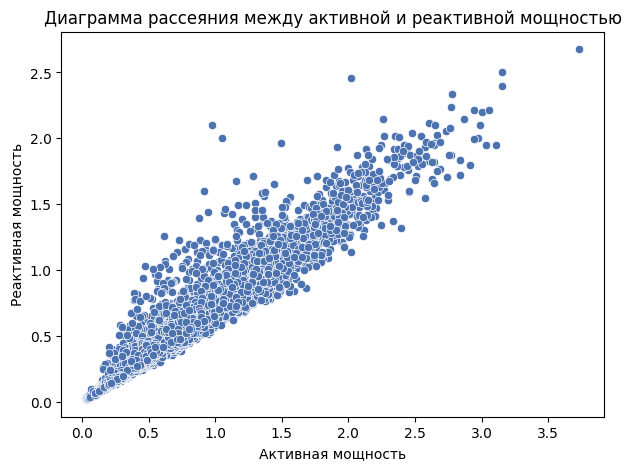

In [14]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=data_arc.query('reactive_power > 0'), x='active_power', y='reactive_power')
plt.title('Диаграмма рассеяния между активной и реактивной мощностью')
plt.xlabel('Активная мощность')
plt.ylabel('Реактивная мощность')
plt.show();

Из представленного графика видно:
- две мощности дествительно **сильно положительно коррелируют**;
- в среднем реактивная мощность составляет порядка **0.7-0.8** от активной мощности.

Рассчитаем на представленных данных насколько действительно в среднем реактивная мощность меньше активной. Таким образом можно будет расчитать новое значение реактивной мощности для замены отрицательных.

In [15]:
(data_arc.query('reactive_power > 0')['reactive_power'] / data_arc.query('index != 9780')['active_power']).mean()

0.7494805681952179

Действительно в среднем реактивная мощность составляет **0.75** от активной. Применим это знание для расчета и замены аномального значения.


In [16]:
# заменим аномальное значение на расчетное
data_arc.loc[data_arc['reactive_power'] < 0, 'reactive_power'] = data_arc['active_power'] * 0.75
# проверим все записи партии с аномально низким значением реактивной мощности 
data_arc.query('key == 2116')

,key,start_time_arc,end_time_arc,active_power,reactive_power
9779,2116,2023-10-01 00:29:52,2023-10-01 00:31:54,0.433266,0.306141
9780,2116,2023-10-01 00:35:50,2023-10-01 00:38:05,0.620265,0.408352
9781,2116,2023-10-01 00:44:48,2023-10-01 00:46:37,0.495782,0.371837
9782,2116,2023-10-01 00:51:51,2023-10-01 00:52:58,0.299368,0.198796


Теперь реактивная мощность соответствует действительности.

Посмотрим на распределения двух мощностей, а так же коробчатые диаграммы.

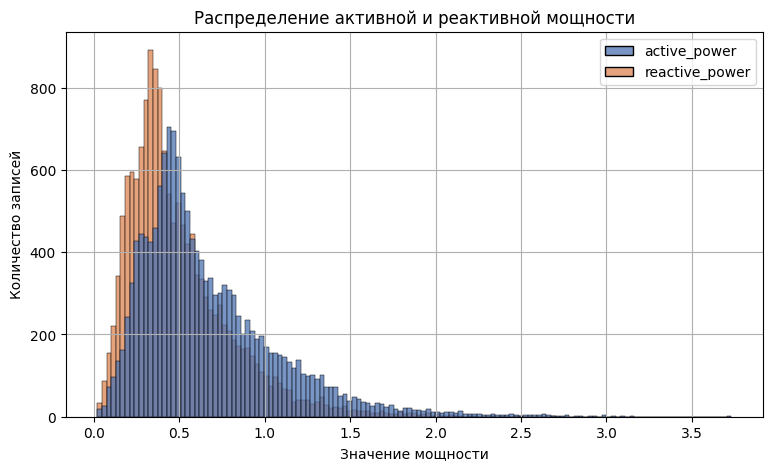

In [17]:
plt.figure(figsize=(9,5))
sns.histplot(data=data_arc[['active_power', 'reactive_power']])
plt.grid()
plt.title('Распределение активной и реактивной мощности')
plt.xlabel('Значение мощности')
plt.ylabel('Количество записей')
plt.show();


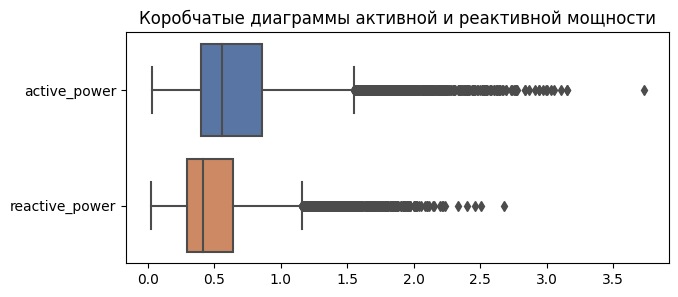

In [18]:
plt.figure(figsize=(7,3))
sns.boxplot(data=data_arc[['active_power', 'reactive_power']], orient='horizontal')
plt.title('Коробчатые диаграммы активной и реактивной мощности')
plt.show();

Из графика распределеня и коробчатых диграмм видно следующее:
- график распределения реактивной мощности **сдвинут немного левее** относительно активной мощности, что еще раз подтверждает факт её более низких значений, чем у активной мощности;
- основной диапазон значений у обоих мощностей лежит в пределах **0.25 - 0.8**;
- в данных есть записи с более высокими значениями мощностей, выходящих за пределы 1,5-кратного межквартильного размаха (**IQR**). Можно предположить что некоторые партии требуют большей мощности для нагрева. 

Посмотрим на гистограмму **количества этапов** нагрева на одну партию. 

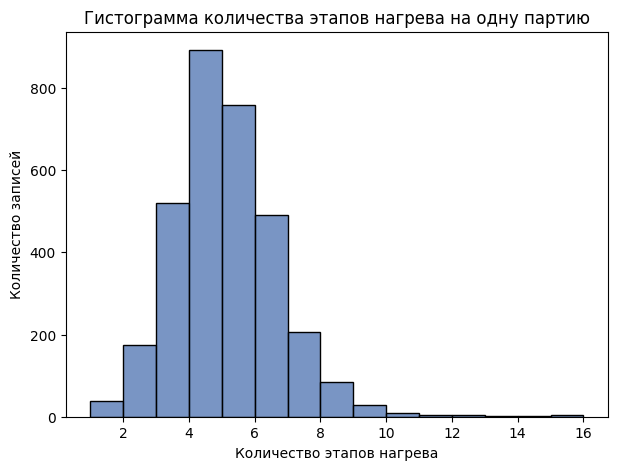

In [19]:
# вывод гистограммы по признаку `heat_count`
plt.figure(figsize=(7,5))
sns.histplot(data_arc.groupby('key')['active_power'].count(), bins=15)
plt.title('Гистограмма количества этапов нагрева на одну партию')
plt.xlabel('Количество этапов нагрева')
plt.ylabel('Количество записей')
plt.show();

Из гистограммы видно:
- чаще всего на одну партию приходится от **4 до 5 этапов нагрева**;
- есть партии, требующие так же либо меньшего количества этапов (**от 1 до 3**) или намного большего (**от 6 до 15**);
- гистограмма имеет **правый хвост** (склонность к высоким предельными значениями).

Расчитаем новый признак `'heat_count'`, который будет хранить текущий номер этапа нагрева в каждой партии.

In [20]:
def get_stage(group):
    '''Функция возвращающая порядковый номер текущего этапа нагрева для каждой партии.
    Используется методе в pandas.transform'''
    for i in range(len(group)):
        yield i + 1

# создание признака `heat_count` - количество этапов нагрева на одну партию
data_arc['heat_count'] = data_arc.groupby('key')['active_power'].transform(get_stage)

Так же проверим **сколько времени** занимает **каждый этап нагрева**.

In [21]:
data_arc['heat_time'] = data_arc['end_time_arc'] - data_arc['start_time_arc']
data_arc['heat_time'].describe()

count                        14876
mean     0 days 00:00:43.894662543
std      0 days 00:55:19.473237060
min              -1 days +00:01:10
25%         0 days 00:01:46.750000
50%                0 days 00:02:27
75%                0 days 00:03:34
max                0 days 00:15:07
Name: heat_time, dtype: object

В `среднем` длительность этапа нагрева - **44 сек.**, `медианное` значение выше и составляет - **2 мин. 27 сек**. Лучше рассматривать `медианное значение` как **более надежное**, так как в данных присутствуют **отрицательные значения**, которые явно говорят об **ошибке**. Посмотрим на такие записи, где время окончания процесса нагрева на временной шкале находятся левее (более раннее) от времени начала.

In [22]:
data_arc.query('heat_time <= "00:00:00"')

,key,start_time_arc,end_time_arc,active_power,reactive_power,heat_count,heat_time
580,126,2023-10-01 23:59:35,2023-10-01 00:01:55,0.527388,0.405463,5,-1 days +00:02:20
1170,257,2023-10-01 23:58:57,2023-10-01 00:00:07,0.268811,0.175647,3,-1 days +00:01:10
1280,280,2023-10-01 23:56:57,2023-10-01 00:01:43,1.197192,0.728587,8,-1 days +00:04:46
1953,421,2023-10-01 23:58:33,2023-10-01 00:01:57,0.774585,0.583186,2,-1 days +00:03:24
2952,642,2023-10-01 23:52:55,2023-10-01 00:03:13,2.415316,1.946081,2,-1 days +00:10:18
3438,745,2023-10-01 23:58:27,2023-10-01 00:00:14,0.403792,0.281718,3,-1 days +00:01:47
4250,913,2023-10-01 23:58:22,2023-10-01 00:01:34,0.787956,0.537366,2,-1 days +00:03:12
4752,1026,2023-10-01 23:59:04,2023-10-01 00:07:07,1.680239,1.400063,2,-1 days +00:08:03
5400,1175,2023-10-01 23:59:25,2023-10-01 00:05:07,1.325558,0.893414,2,-1 days +00:05:42
6456,1404,2023-10-01 23:56:33,2023-10-01 00:01:05,1.217748,0.833978,4,-1 days +00:04:32


Как и ожидалось ошибка в дате окончания этапа нагрева. День месяца указан прежний, хотя должен учитываться следующий день. Скорректируем такие значения.

In [23]:
# создадим отдельный датафрейм с некорректными датами
df_with_error_data = data_arc.query('heat_time <= "00:00:00"')
# скорректируем даты в колонке `end_time_arc` в записях, где необходимо добавить один день
data_arc.loc[df_with_error_data.index, 'end_time_arc'] = df_with_error_data['end_time_arc'] + pd.Timedelta(days=1)

In [24]:
# снова рассчитаем длительность каждого этапа нагрева
data_arc['heat_time'] = data_arc['end_time_arc'] - data_arc['start_time_arc']
# выведем статистики по новому признаку
data_arc['heat_time'].describe()

count                        14876
mean     0 days 00:02:51.670946490
std      0 days 00:01:38.186802680
min                0 days 00:00:11
25%                0 days 00:01:47
50%                0 days 00:02:27
75%                0 days 00:03:34
max                0 days 00:15:07
Name: heat_time, dtype: object

**Отрицательных** значений в длительности теперь **нет**. `Среднее` и `медианное` значения теперь близки. Так как в данных есть длительности достигающие **15 минут**, `среднее` значение стало даже немного **выше** `медианного` и составляет - **2 мин. 52 сек.**

In [25]:
# переведем расчитанную длительность в секунды с типом int
data_arc['heat_time'] = (data_arc['heat_time'].astype(np.int64) // 10 ** 9).astype(np.int32)

Так же интересно расчитать время между началами двух ближайших этапов нагрева в каждой партии. Для начала проверим монотонность по признаку `'start_time_arc'`.

In [26]:
data_arc['start_time_arc'].is_monotonic

False

Данные не монотонны. Рассчитаем длительность от начала предыдущего до начала текущего времени этапа нагрева. Для этого создадим признак `'time_between'`.

In [27]:
def get_time_between(group):
    
    '''Функция возвращающая длительность между началами двух этапов.
     Используется методе в pandas.transform'''
    
    return group - group.shift(1, fill_value=group.iloc[0])
        
# подситываем длительность между окончанием и началом двух этапов
data_arc['time_between'] = data_arc.groupby('key')['start_time_arc'].transform(get_time_between)
# посмотрим на возможные отрицательные значения длительности
data_arc.query('time_between < "00:00:00"').head(10)

,key,start_time_arc,end_time_arc,active_power,reactive_power,heat_count,heat_time,time_between
83,18,2023-10-01 00:05:08,2023-10-01 00:06:09,0.259736,0.170379,5,61,-1 days +00:10:17
197,44,2023-10-01 00:32:02,2023-10-01 00:34:36,0.537892,0.426978,8,154,-1 days +01:44:31
209,45,2023-10-01 00:09:50,2023-10-01 00:14:57,1.336049,0.941818,8,307,-1 days +00:31:33
214,46,2023-10-01 00:00:02,2023-10-01 00:06:06,1.416315,0.923294,3,364,-1 days +00:09:53
347,74,2023-10-01 00:02:20,2023-10-01 00:05:29,0.743022,0.566924,3,189,-1 days +00:09:10
487,104,2023-10-01 00:07:11,2023-10-01 00:08:43,0.417363,0.270225,3,92,-1 days +00:11:11
1076,232,2023-10-01 00:00:55,2023-10-01 00:03:50,0.663512,0.584284,4,175,-1 days +00:03:38
1281,280,2023-10-01 00:05:53,2023-10-01 00:07:00,0.282393,0.170042,9,67,-1 days +00:08:56
1571,336,2023-10-01 00:04:45,2023-10-01 00:07:12,0.661800,0.437790,5,147,-1 days +00:11:20
1954,421,2023-10-01 00:03:32,2023-10-01 00:07:54,1.137478,0.815643,3,262,-1 days +00:04:59


Действительно есть партии, которые имеют отрицательную длительность между этапами. После просмотра многих партий выявлена та же самая ошибка в данных, связанная с тем, что не всегда после полуночи дата указана с учетом следующих суток. Выведем примеры некоторых таких партий для наглядности.

In [28]:
def highlight_lesserthan(s, threshold, column):

    '''Функция подсвечивает строки с аномальными значениями, ниже
    установленного порога threshold по колонке column.'''
    
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] < threshold
    return ['background-color: yellow' if is_max.any() else '' for v in is_max]

# выведем информацию по партиям 2798 и 45, где присутствуют аномальные значения длительности
data_arc.query('key == 2798 or key == 45').style.apply(highlight_lesserthan, threshold=pd.Timedelta(0, "d"), column='time_between', axis=1)

,key,start_time_arc,end_time_arc,active_power,reactive_power,heat_count,heat_time,time_between
202,45,2023-10-01 23:02:37,2023-10-01 23:05:52,0.667737,0.554781,1,195,0 days 00:00:00
203,45,2023-10-01 23:08:55,2023-10-01 23:15:53,1.765750,1.296387,2,418,0 days 00:06:18
204,45,2023-10-01 23:18:43,2023-10-01 23:21:48,0.824910,0.561500,3,185,0 days 00:09:48
205,45,2023-10-01 23:22:53,2023-10-01 23:26:00,0.837125,0.566057,4,187,0 days 00:04:10
206,45,2023-10-01 23:27:47,2023-10-01 23:30:13,0.650173,0.455494,5,146,0 days 00:04:54
207,45,2023-10-01 23:32:14,2023-10-01 23:37:01,1.257520,0.970228,6,287,0 days 00:04:27
208,45,2023-10-01 23:38:17,2023-10-01 23:40:21,0.556318,0.368146,7,124,0 days 00:06:03
209,45,2023-10-01 00:09:50,2023-10-01 00:14:57,1.336049,0.941818,8,307,-1 days +00:31:33
210,45,2023-10-01 00:15:58,2023-10-01 00:19:00,0.823449,0.543888,9,182,0 days 00:06:08
211,45,2023-10-01 00:21:20,2023-10-01 00:23:05,0.465433,0.305233,10,105,0 days 00:05:22


Для того чтобы учесть такие ошибки, отбросим в колонке `'time_between'` 1 день и возьмем значение по модулю. А далее приведем значения к секундам с типом **int**.

In [29]:
data_arc['time_between'] = ((data_arc['time_between'] - pd.to_timedelta(data_arc['time_between'].dt.days, unit='d'))
.astype(np.int64) // 10 ** 9).astype(np.int32)

# выведем информацию по партиям 2798 и 45, где скорректированы и преобразованы аномальные значения длительности
data_arc.query('key == 2798 or key == 45').style.apply(highlight_lesserthan, threshold=0, column='time_between', axis=1)

,key,start_time_arc,end_time_arc,active_power,reactive_power,heat_count,heat_time,time_between
202,45,2023-10-01 23:02:37,2023-10-01 23:05:52,0.667737,0.554781,1,195,0
203,45,2023-10-01 23:08:55,2023-10-01 23:15:53,1.765750,1.296387,2,418,378
204,45,2023-10-01 23:18:43,2023-10-01 23:21:48,0.824910,0.561500,3,185,588
205,45,2023-10-01 23:22:53,2023-10-01 23:26:00,0.837125,0.566057,4,187,250
206,45,2023-10-01 23:27:47,2023-10-01 23:30:13,0.650173,0.455494,5,146,294
207,45,2023-10-01 23:32:14,2023-10-01 23:37:01,1.257520,0.970228,6,287,267
208,45,2023-10-01 23:38:17,2023-10-01 23:40:21,0.556318,0.368146,7,124,363
209,45,2023-10-01 00:09:50,2023-10-01 00:14:57,1.336049,0.941818,8,307,1893
210,45,2023-10-01 00:15:58,2023-10-01 00:19:00,0.823449,0.543888,9,182,368
211,45,2023-10-01 00:21:20,2023-10-01 00:23:05,0.465433,0.305233,10,105,322


Создадим еще признаки на основе уже имеющихся:
- кумулятивное время нагрева по каждой партии - `'heat_time_cum'`;
- кумулятивное время между началами двух этапов нагрева - `'time_between_cum'`;
- отношение кумулятивного времени между этапами к кумулятивному времени нагрева - `'break_ratio'`;
- полную мощность (`'power'`) расчитанную по следующей формуле:

$$ S = \sqrt{{A^2 + R^2}} $$

, где **S - полная мощность, A - активная мощность, R - реактивная мощность**;
- кумулятивная полная мощность - `'power_cum'`;
- импульс нагрева (переданная энергия за время нагрева), просто как произведение `полной мощности` на `время нагрева` - `'energy'`;
- кумулятивная полная энергия - `'energy_cum'`.

In [30]:
data_arc['heat_time_cum'] = data_arc.groupby('key')['heat_time'].transform('cumsum')
data_arc['time_between_cum'] = data_arc.groupby('key')['time_between'].transform('cumsum')
data_arc['break_ratio_cum'] = data_arc['time_between_cum'] / data_arc['heat_time_cum']
data_arc['power'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)
data_arc['power_cum'] = data_arc.groupby('key')['power'].transform('cumsum')
data_arc['energy'] = data_arc['power'] * data_arc['heat_time']
data_arc['energy_cum'] = data_arc.groupby('key')['energy'].transform('cumsum')

# выведем первые 10 записей для проверик расчетов
data_arc.head(10)

,key,start_time_arc,end_time_arc,active_power,reactive_power,heat_count,heat_time,time_between,heat_time_cum,time_between_cum,break_ratio_cum,power,power_cum,energy,energy_cum
0,1,2023-10-01 11:02:14,2023-10-01 11:06:02,0.976059,0.687084,1,228,0,228,0,0.000000,1.193639,1.193639,272.149755,272.149755
1,1,2023-10-01 11:07:28,2023-10-01 11:10:33,0.805607,0.520285,2,185,314,413,314,0.760291,0.959010,2.152649,177.416785,449.566540
2,1,2023-10-01 11:11:44,2023-10-01 11:14:36,0.744363,0.498805,3,172,256,585,570,0.974359,0.896038,3.048687,154.118502,603.685042
3,1,2023-10-01 11:18:14,2023-10-01 11:24:19,1.659363,1.062669,4,365,390,950,960,1.010526,1.970470,5.019156,719.221394,1322.906436
4,1,2023-10-01 11:26:09,2023-10-01 11:28:37,0.692755,0.414397,5,148,475,1098,1435,1.306922,0.807239,5.826395,119.471318,1442.377754
5,2,2023-10-01 11:34:14,2023-10-01 11:36:31,0.438063,0.283043,1,137,0,137,0,0.000000,0.521549,0.521549,71.452170,71.452170
6,2,2023-10-01 11:38:50,2023-10-01 11:44:28,1.296415,0.892914,2,338,276,475,276,0.581053,1.574162,2.095711,532.066853,603.519023
7,2,2023-10-01 11:46:19,2023-10-01 11:48:25,0.490377,0.305281,3,126,449,601,725,1.206323,0.577638,2.673349,72.782394,676.301418
8,2,2023-10-01 11:49:48,2023-10-01 11:53:18,0.827743,0.516874,4,210,209,811,934,1.151665,0.975867,3.649216,204.932148,881.233565
9,3,2023-10-01 12:06:54,2023-10-01 12:11:34,1.062053,0.671494,1,280,0,280,0,0.000000,1.256527,1.256527,351.827647,351.827647


По условиям задачи каждая запись в данных поданая для обучения моделей должна соответствовать одной партии. В связи с этим преобразуем таблицу согласно условиям, оставив следующие признаки: 

In [31]:
agg_arc = {
    'start_time_arc' : 'first',
    'end_time_arc'   : 'last',
    'active_power'   : 'mean',
    'reactive_power' : 'mean',
    'heat_count'     : 'last',
    'heat_time_cum'  : 'last',
    'time_between_cum' : 'last',
    'break_ratio_cum'  : 'last',  
    'power_cum'        : 'last',
    'energy_cum'       : 'last'
}

data_arc_new = data_arc.groupby('key').agg(agg_arc)
data_arc_new

,start_time_arc,end_time_arc,active_power,reactive_power,heat_count,heat_time_cum,time_between_cum,break_ratio_cum,power_cum,energy_cum
key,,,,,,,,,,
1,2023-10-01 11:02:14,2023-10-01 11:28:37,0.975629,0.636648,5,1098,1435,1.306922,5.826395,1442.377754
2,2023-10-01 11:34:14,2023-10-01 11:53:18,0.763150,0.499528,4,811,934,1.151665,3.649216,881.233565
3,2023-10-01 12:06:54,2023-10-01 12:32:19,0.505176,0.319815,5,655,1460,2.229008,2.989534,525.066777
4,2023-10-01 12:39:37,2023-10-01 12:57:50,0.802313,0.515074,4,741,815,1.099865,3.814962,796.911309
5,2023-10-01 13:11:13,2023-10-01 13:33:55,0.836793,0.563161,4,869,1291,1.485616,4.035758,1199.137958
...,...,...,...,...,...,...,...,...,...,...
3237,2023-10-01 22:41:18,2023-10-01 23:03:48,0.786493,0.565692,5,909,1214,1.335534,4.844982,958.336236
3238,2023-10-01 23:26:18,2023-10-01 23:41:28,0.702176,0.560394,3,546,740,1.355311,2.696542,555.867370
3239,2023-10-01 01:26:53,2023-10-01 02:15:43,0.583344,0.388952,8,1216,2805,2.306743,5.611883,1013.067719


### Данные о подаче сыпучих материалов

In [32]:
# выведем первые и последние записи из таблицы
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


Всего в таблице **3 129 записей** и **16 признаков**.  Признак `'key'` ключевой для объединения таблиц, обозначает номер партии.

Посмотрим, совпадает ли список отсутствующих номеров партий в данной таблице с таблицей `'data_arc'`.

In [33]:
def print_missing_parts(parts: set):
    # номера партий, отсутствующиев данных запишем в список 
    missing_pats_in_bulk = list(set(range(1, 3242)) - parts)
    print(missing_pats_in_bulk)
    print('Количество отсутствующих партий: ', len(missing_pats_in_bulk))
    # применим операцию разности для множеств, чтобы определить
    # совпадают ли все пропуски партий в обоих датафреймах
    print(set(missing_pats_in_bulk) - set(missing_pats))
    print('Количество дополнительно отсутствующих партий: ', len((set(missing_pats_in_bulk) - set(missing_pats))))

# вызовем функцию print_missing_parts
print_missing_parts(set(data_bulk['key']))

[2056, 529, 540, 1566, 2595, 1062, 2599, 2600, 41, 42, 2608, 51, 52, 53, 54, 55, 56, 2103, 2625, 2628, 72, 80, 81, 1105, 1623, 607, 1133, 110, 3182, 1656, 2683, 3200, 3207, 3216, 2195, 2196, 661, 2197, 151, 2198, 2216, 2217, 683, 2738, 2739, 2231, 188, 195, 1221, 710, 225, 2278, 1268, 1783, 766, 2816, 2821, 2310, 269, 1300, 1818, 302, 2863, 2356, 1334, 830, 2884, 2373, 330, 331, 332, 2891, 2390, 343, 350, 355, 2408, 874, 1911, 1402, 382, 2434, 2446, 2460, 1437, 931, 2468, 933, 934, 1959, 2469, 2471, 1974, 1979, 2491, 960, 961, 964, 966, 3018, 3026, 983, 984, 2009, 2010, 3047, 1517, 1518, 2031, 506, 2043, 1535]
Количество отсутствующих партий:  112
{2816, 2821, 2310, 2056, 269, 1818, 1566, 2595, 1062, 2599, 2600, 302, 2863, 2608, 51, 52, 53, 54, 55, 56, 1334, 830, 2625, 2628, 2884, 72, 330, 331, 332, 2891, 80, 81, 1105, 2390, 1623, 343, 350, 2408, 874, 110, 3182, 1911, 1656, 1402, 2434, 3216, 2195, 2196, 661, 2197, 151, 2198, 2460, 931, 2468, 933, 934, 1959, 2216, 2217, 2471, 2738, 2739

Итоговое множество не пустое, так как в таблице `'data_bulk'` отсутствует информация и по другим номерам партий. Все данные по таким партиям необходимо исключить, так как из описания задания от Заказчика четко указано, что `'во все партии точно добавлялись сыпучие и проволочные материалы, везде была выполнена продувка газом и сплав всегда нагревался'`.

In [34]:
# выведем общую информацию по таблице
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [35]:
# посмотрим на описательные статистики 
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Из особенностей в данных:
- **нет** аномальных значений (**отрицательных**);
- **материал №8** добавляли единственный раз в представленных данных;
- **максимальное количество**, которое добавляли в партию у **материла №12** (значение достигает **1849**). Вряд ли это ошибка в данных, так как порядок значений в пределах разумного.

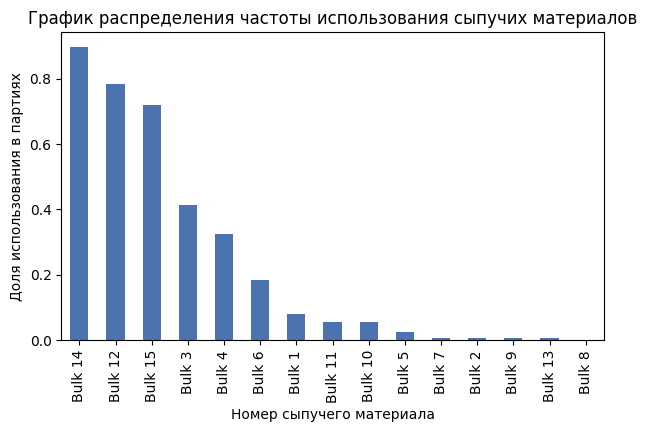

In [36]:
plt.figure(figsize = (7,4))
(~data_bulk.iloc[:, 1:].isnull()).mean().sort_values(ascending=False).plot(kind='bar')
plt.title('График распределения частоты использования сыпучих материалов')
plt.ylabel('Доля использования в партиях')
plt.xlabel('Номер сыпучего материала')
plt.show()

Чаще всего используются материалы №14, №12, №15. Реже - №3, №4, №6. Остальные практически не используются

В таблице **есть пропущенные значения**. Так как не все сыпучие материалы используются в каждой партии, пропуски в данных означают, что данные материалы не были добавлены. В таком случае пропуски можно заменить нулевым зачением. Названия колонок также необходимо привести к общепринятому стилю.

In [37]:
# установим индекс равный ключу `key`
data_bulk = data_bulk.set_index('key')
# переименуем колонки
data_bulk.columns = ['bulk_' + str(i) for i in range(1, 16)]
# заполним пропущенные значения нулями
data_bulk.fillna(0, inplace=True)
# выведем 10 случайных записи
data_bulk.sample(10)

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
2801,0.0,0.0,0.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,258.0,0.0,100.0,106.0
2794,0.0,0.0,0.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,242.0,0.0
2503,0.0,0.0,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,128.0,205.0
2977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.0,0.0,202.0,0.0,96.0,102.0
2818,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,260.0,0.0,118.0,224.0
3006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,0.0,208.0,0.0,146.0,154.0
2450,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,117.0,205.0
181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,154.0,203.0
160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,104.0,203.0


Создадим признак `'sum_bulk'`, обозначающий сколько всего было добавлено **объема** сыпучих материалов в партию.

In [38]:
data_bulk['sum_bulk'] = data_bulk.sum(axis=1)

Создадим признак 'count_bulk', обозначающий сколько всего было добавлено **типов/партий** сыпучих материалов в партию.

In [39]:
def get_count_bulk(row):
    count = 0
    for col in row:
        count += 1 if col != 0.0 else 0
    return count
        
data_bulk['count_bulk'] = data_bulk.iloc[:, :15].agg(get_count_bulk, axis=1)
# выведем 10 случайных записей
data_bulk.sample(10)

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,sum_bulk,count_bulk
key,,,,,,,,,,,,,,,,,
2971,0.0,0.0,84.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0,2
1954,0.0,0.0,166.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,128.0,157.0,655.0,4
2536,0.0,0.0,0.0,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,1
298,73.0,0.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,518.0,0.0,379.0,205.0,1212.0,5
620,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,102.0,203.0,551.0,4
1603,0.0,0.0,0.0,0.0,0.0,141.0,0.0,0.0,0.0,0.0,0.0,461.0,0.0,352.0,210.0,1164.0,4
139,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,228.0,202.0,558.0,4
478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,142.0,104.0,449.0,3
247,0.0,0.0,0.0,0.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0,1


**Провдем исследования таблицы с временем добавления сыпучих материалов**.

In [40]:
# выведем первые и последние записи из таблицы
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:03:52,NaN,11:03:52,11:03:52
1,2,NaN,NaN,NaN,11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:40:20,NaN,11:40:20,11:40:20
2,3,NaN,NaN,NaN,12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:09:40,NaN,12:09:40,12:09:40
3,4,NaN,NaN,NaN,12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:41:24,NaN,12:41:24,12:41:24
4,5,NaN,NaN,NaN,13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13:12:56,NaN,13:12:56,13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22:46:52,NaN,22:46:52,22:46:52
3125,3238,NaN,NaN,23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23:33:09,NaN,23:33:09,23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,01:51:58,NaN,NaN,NaN,NaN,NaN,01:39:41,NaN,01:33:25,01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02:41:27,02:41:27


Всего в таблице **3 129 записей** и **16 признаков**.  Признак `'key'` ключевой для объединения таблиц, обозначает номер партии.

In [41]:
# выведем общую информацию по таблице
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Таблицы `'data_bulk'` и `'data_bulk_time'` идентичны по количеству строк и столбцов, а так же имеют одни и те же пропуски в данных. Для дальнейшей работы приведем столбцы с временем к типу **datetime**.

In [42]:
# установим индекс равный ключу `key`
data_bulk_time = data_bulk_time.set_index('key')

for i in range(1, 16):
    data_bulk_time['Bulk ' + str(i)] = pd.to_datetime(data_bulk_time['Bulk ' + str(i)])
# повторно выведем общую информацию по таблице
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Bulk 1   252 non-null    datetime64[ns]
 1   Bulk 2   22 non-null     datetime64[ns]
 2   Bulk 3   1298 non-null   datetime64[ns]
 3   Bulk 4   1014 non-null   datetime64[ns]
 4   Bulk 5   77 non-null     datetime64[ns]
 5   Bulk 6   576 non-null    datetime64[ns]
 6   Bulk 7   25 non-null     datetime64[ns]
 7   Bulk 8   1 non-null      datetime64[ns]
 8   Bulk 9   19 non-null     datetime64[ns]
 9   Bulk 10  176 non-null    datetime64[ns]
 10  Bulk 11  177 non-null    datetime64[ns]
 11  Bulk 12  2450 non-null   datetime64[ns]
 12  Bulk 13  18 non-null     datetime64[ns]
 13  Bulk 14  2806 non-null   datetime64[ns]
 14  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15)
memory usage: 391.1 KB


Для каждой партии расчитаем следующие признаки:
- время первого добавления сыпучих материалов - `'start_time_bulk'`;
- время добавления заключительной партии сыпучих материалов - `'end_time_bulk'`;
- время от начала добавления первой партии сыпучих материалов до времени окончания добавления последней партии - `'bulk_time'`.

In [43]:
data_bulk_time['start_time_bulk'] = data_bulk_time.min(axis=1)
data_bulk_time['end_time_bulk'] = data_bulk_time.max(axis=1)
data_bulk_time['bulk_time'] = ((data_bulk_time['end_time_bulk'] - data_bulk_time['start_time_bulk']).astype(np.int64) // 10 ** 9).astype(int)
# удалим все признаки кроме расчитанных
data_bulk_time = data_bulk_time.iloc[:, -3:]
# выведем итоговую таблицу
data_bulk_time

,start_time_bulk,end_time_bulk,bulk_time
key,,,
1,2023-10-01 11:03:52,2023-10-01 11:21:30,1058
2,2023-10-01 11:40:20,2023-10-01 11:46:38,378
3,2023-10-01 12:09:40,2023-10-01 12:31:06,1286
4,2023-10-01 12:41:24,2023-10-01 12:48:43,439
5,2023-10-01 13:12:56,2023-10-01 13:18:50,354
...,...,...,...
3237,2023-10-01 22:46:52,2023-10-01 22:51:28,276
3238,2023-10-01 23:33:09,2023-10-01 23:39:11,362
3239,2023-10-01 01:33:25,2023-10-01 01:51:58,1113


In [44]:
data_bulk_time.describe(include='all', datetime_is_numeric=True)

,start_time_bulk,end_time_bulk,bulk_time
count,3129,3129,3129.000000
mean,2023-10-01 11:39:59.318312704,2023-10-01 11:59:15.682646272,1156.364334
min,2023-10-01 00:00:01,2023-10-01 00:01:00,0.000000
25%,2023-10-01 05:40:19,2023-10-01 06:01:18,211.000000
50%,2023-10-01 11:30:00,2023-10-01 11:47:40,414.000000
75%,2023-10-01 17:37:57,2023-10-01 17:58:12,744.000000
max,2023-10-01 23:56:40,2023-10-01 23:59:30,86198.000000
std,NaN,NaN,7059.208890


Даты добавления сыпучих материалов соответствуют датам нагрева стали. В `среднем` длительность добавления сыпучих материалов **1 156 сек.**, `медианное` значение - **414 сек**. Это связано с тем, что в каких-то случаях интервал между началом добавления первой партии и окончанием последней партии сыпучих материалов длительный и мог составлять до **86 198 сек.** 

### Данные о подаче проволочных материалов

Данные о подаче проволочных материалов будут обработаны аналогично сыпучим материалам.

In [45]:
# выведем первые и последние записи из таблицы
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Всего в таблице **3 081 запись** и **10 признаков**.  Признак `'key'` ключевой для объединения таблиц, обозначает номер партии.

In [46]:
# вызовем функцию print_missing_parts
print_missing_parts(set(data_wire['key']))

[529, 540, 1564, 1565, 1566, 41, 42, 51, 52, 53, 54, 55, 56, 2103, 2624, 2625, 2626, 2627, 2628, 2629, 1102, 1103, 1104, 1105, 81, 82, 83, 84, 85, 1106, 88, 1107, 607, 109, 1133, 1646, 2683, 3200, 3207, 2195, 2196, 2197, 2198, 1184, 2214, 2215, 2216, 2217, 2218, 683, 2219, 2236, 2238, 195, 197, 710, 711, 712, 713, 714, 715, 1743, 1744, 209, 210, 211, 212, 1745, 1746, 1747, 1748, 1758, 2788, 2789, 2278, 2790, 744, 2791, 2792, 748, 754, 755, 766, 2814, 2815, 269, 1300, 1817, 1818, 796, 797, 798, 799, 800, 2846, 2847, 2848, 2849, 2850, 1836, 2863, 2356, 2871, 2360, 2872, 2873, 2874, 2875, 2876, 2367, 2368, 2369, 2370, 2373, 841, 330, 331, 332, 2388, 2389, 2390, 2391, 2392, 2393, 355, 1379, 1380, 375, 376, 377, 378, 382, 2446, 1946, 1437, 929, 930, 931, 932, 933, 934, 2469, 1977, 1978, 1979, 2491, 2010, 3035, 3036, 3037, 3038, 3039, 3040, 2031, 1525, 1526, 1527, 1528, 506, 2043]
Количество отсутствующих партий:  160
{1564, 1565, 1566, 51, 52, 53, 54, 55, 56, 2624, 2625, 2626, 2627, 2628, 2

В таблице `'data_wire'` ещё больше отсутствует номеров партий чем в таблицах `'data_arc'` и `'data_bulk'`. Все данные по таким партиям необходимо исключить, так как из описания задания от Заказчика четко указано, что `'во все партии точно добавлялись сыпучие и проволочные материалы, везде была выполнена продувка газом и сплав всегда нагревался'`.

In [47]:
# выведем общую информацию по таблице
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [48]:
# посмотрим на описательные статистики 
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Из особенностей в данных:
- **нет** аномальных значений (**отрицательных**);
- **материал №5** добавляли единственный раз в представленных данных;
- **максимальное количество**, которое добавляли в партию у **материла №1** (значение достигает **330**). 

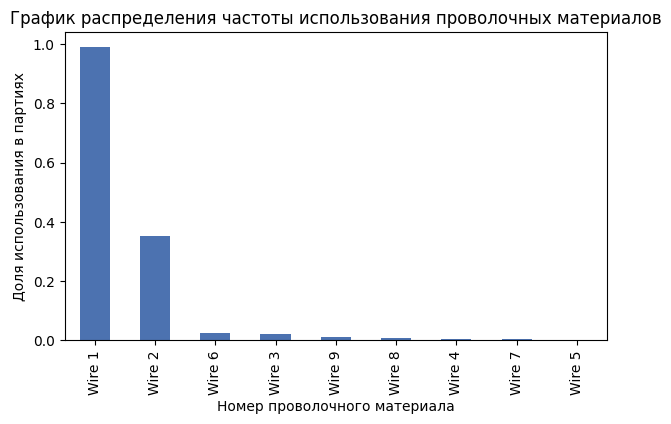

In [49]:
plt.figure(figsize = (7,4))
(~data_wire.iloc[:, 1:].isnull()).mean().sort_values(ascending=False).plot(kind='bar')
plt.title('График распределения частоты использования проволочных материалов')
plt.ylabel('Доля использования в партиях')
plt.xlabel('Номер проволочного материала')
plt.show()

Чаще всего используются материалы №1, №2. Остальные практически не используются

В таблице **есть пропущенные значения**. Так как не все проволочные материалы используются в каждой партии, пропуски в данных означают, что данные материалы не были добавлены. В таком случае пропуски можно заменить нулевым зачением. Названия колонок также необходимо привести к общепринятому стилю.

In [50]:
# установим индекс равный ключу `key`
data_wire = data_wire.set_index('key')
# переименуем колонки
data_wire.columns=['wire_' + str(i) for i in range(1, 10)]
# заполним пропущенные значения нулями
data_wire.fillna(0, inplace=True)
# выведем 10 случайных записи
data_wire.sample(10)

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1996,119.071679,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
2470,115.053116,115.090560,0.0,0.0,0.0,0.0,0.0,0.0,11.3568
1271,94.114800,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
1130,58.125599,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
2054,60.016315,45.149521,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
403,22.229999,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
2631,117.324486,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
2457,139.164490,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
588,130.244400,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000


Создадим признак `'sum_wire'`, обозначающий сколько всего было добавлено проволочных материалов в партию.

In [51]:
data_wire['sum_wire'] = data_wire.sum(axis=1)

Создадим признак `'count_wire'`, обозначающий сколько всего было добавлено **типов/партий** проволочных материалов в партию.

In [52]:
def get_count_wire(row):
    count = 0
    for col in row:
        count += 1 if col != 0.0 else 0
    return count
        
data_wire['count_wire'] = data_wire.iloc[:, :9].agg(get_count_wire, axis=1)
# выведем 10 случайных записей
data_wire.sample(10)

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,sum_wire,count_wire
key,,,,,,,,,,,
2870,24.984961,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.984961,1
751,65.332798,21.956478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.289276,2
1549,124.066803,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124.066803,1
2013,117.193443,40.112801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,157.306244,2
2495,89.150879,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.150879,1
1996,119.071679,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.071679,1
1309,178.308000,50.186237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,228.494237,2
2008,140.212814,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.212814,1
1912,165.459839,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165.459839,1


**Провдем исследования таблицы с временем добавления проволочных материалов**.

In [53]:
# выведем первые и последние записи из таблицы
data_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,13:18:15,13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Всего в таблице **3 081 запись** и **10 признаков**.  Признак `'key'` ключевой для объединения таблиц, обозначает номер партии.

In [54]:
# выведем общую информацию по таблице
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Таблицы `'data_wire'` и `'data_wire_time'` так же идентичны по количеству строк и столбцов и имеют одни и те же пропуски в данных. Для дальнейшей работы приведем столбцы с временем к типу **datetime**.

In [55]:
# установим индекс равный ключу `key`
data_wire_time = data_wire_time.set_index('key')
# переименуем колонки
for i in range(1, 10):
    data_wire_time['Wire ' + str(i)] = pd.to_datetime(data_wire_time['Wire ' + str(i)])
# повторно выведем общую информацию по таблице
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Wire 1  3055 non-null   datetime64[ns]
 1   Wire 2  1079 non-null   datetime64[ns]
 2   Wire 3  63 non-null     datetime64[ns]
 3   Wire 4  14 non-null     datetime64[ns]
 4   Wire 5  1 non-null      datetime64[ns]
 5   Wire 6  73 non-null     datetime64[ns]
 6   Wire 7  11 non-null     datetime64[ns]
 7   Wire 8  19 non-null     datetime64[ns]
 8   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9)
memory usage: 240.7 KB


Для каждой партии расчитаем следующие признаки:
- время первого добавления проволочных материалов - `'start_time_wire'`;
- время добавления заключительной партии проволочных материалов - `'end_time_wire'`;
- время от начала добавления первой партии проволочных материалов до времени окончания добавления последней партии - `'wire_time'`.

In [56]:
data_wire_time['start_time_wire'] = data_wire_time.min(axis=1)
data_wire_time['end_time_wire'] = data_wire_time.max(axis=1)
data_wire_time['wire_time'] = ((data_wire_time['end_time_wire'] - data_wire_time['start_time_wire']).astype(np.int64) // 10 ** 9).astype(int)
# удалим все признаки кроме расчитанных
data_wire_time = data_wire_time.iloc[:, -3:]
# выведем итоговую таблицу
data_wire_time

,start_time_wire,end_time_wire,wire_time
key,,,
1,2023-10-01 11:11:41,2023-10-01 11:11:41,0
2,2023-10-01 11:46:10,2023-10-01 11:46:10,0
3,2023-10-01 12:13:47,2023-10-01 12:13:47,0
4,2023-10-01 12:48:05,2023-10-01 12:48:05,0
5,2023-10-01 13:18:15,2023-10-01 13:32:06,831
...,...,...,...
3237,2023-10-01 22:50:20,2023-10-01 22:50:20,0
3238,2023-10-01 23:38:24,2023-10-01 23:38:24,0
3239,2023-10-01 01:50:43,2023-10-01 01:50:43,0


In [57]:
data_wire_time.describe(include='all', datetime_is_numeric=True)

,start_time_wire,end_time_wire,wire_time
count,3081,3081,3081.000000
mean,2023-10-01 11:48:49.245374464,2023-10-01 11:54:13.143784448,323.898410
min,2023-10-01 00:00:37,2023-10-01 00:00:51,0.000000
25%,2023-10-01 05:46:25,2023-10-01 05:50:12,0.000000
50%,2023-10-01 11:37:22,2023-10-01 11:41:37,0.000000
75%,2023-10-01 17:51:14,2023-10-01 17:58:09,80.000000
max,2023-10-01 23:59:55,2023-10-01 23:59:55,86046.000000
std,NaN,NaN,3806.657121


Даты добавления проволочных материалов соответствуют датам нагрева стали. В `среднем` длительность периода добавления проволочных материалов **324 сек.**, `медианное` значение - **0**. Это связано с тем, что в большинстве случаев добавлялся только **один тип** проволочных материалов. 

### Данные о продувке сплава газом

In [58]:
# выведем первые и последние записи из таблицы 
data_gas

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


Всего в таблице **3 239 записей** и **2 признака**.  Признак `'key'` ключевой для объединения таблиц, обозначает номер партии.

Посмотрим, совпадает ли список отсутствующих номеров партий в данной таблице с таблицей `'data_arc'`.

In [59]:
# вызовем функцию print_missing_parts
print_missing_parts(set(data_gas['key']))

[193, 259]
Количество отсутствующих партий:  2
{193, 259}
Количество дополнительно отсутствующих партий:  2


Все данные по таким партиям необходимо исключить, так как из описания задания от Заказчика четко указано, что `'во все партии точно добавлялись сыпучие и проволочные материалы, везде была выполнена продувка газом и сплав всегда нагревался'`.

In [60]:
# выведем общую информацию по таблице
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [61]:
print(len(data_gas['key'].unique()))

# установим индекс равный ключу `key`
data_gas = data_gas.set_index('key')

3239


Все записи в таблице уникальны по ключу `'key'`, значит в каждой партии была только одна продувка газом.

In [62]:
# посмотрим на описательные статистики 
data_gas.describe()

,gas
count,3239.000000
mean,11.002062
std,6.220327
min,0.008399
25%,7.043089
50%,9.836267
75%,13.769915
max,77.995040


Из особенностей в данных:
- **нет** аномальных значений (в том числе **отрицательных**);
- `'среднее'` значение объема газа, используемого для продувки сплава составляет **11**, `'медианное'` немного меньше - **9.8**. Видимо для некоторых партий используется больший объем газа для продувки.

Построим гистограмму распределения объемов газа.

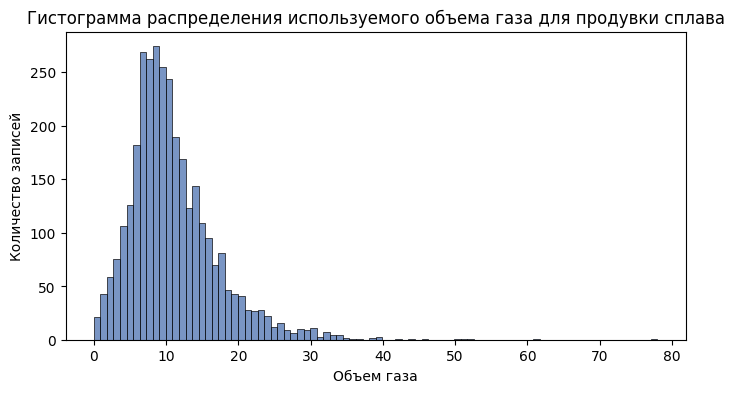

In [63]:
plt.figure(figsize=(8,4))
sns.histplot(data=data_gas['gas'])
plt.title('Гистограмма распределения используемого объема газа для продувки сплава')
plt.xlabel('Объем газа')
plt.ylabel('Количество записей')
plt.show();

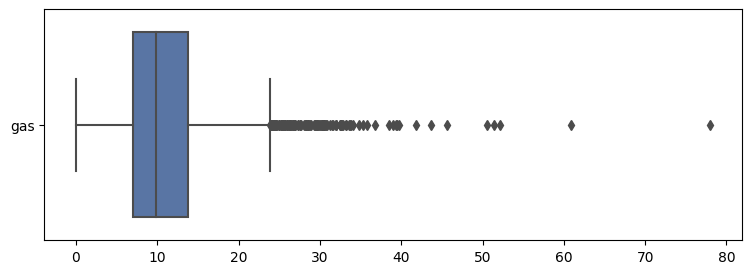

In [64]:
# дополнительно выведем коробчатую диаграмму
plt.figure(figsize=(9,3))
sns.boxplot(data=data_gas, orient='horizontal')
plt.show();

Из графиков следуют следующие выводы:
- в большей части партий объем подаваемого газа составляет около **10**,
- `межквартильный размах` - **от 0 до 24**;
- в некторых партиях используется больший объем газа вплоть до **78**. На гистограмме виден **длинный правый хвост**.

### Результаты измерения температуры. Исследование целевого признака.

In [65]:
# выведем первые и последние записи из таблицы 
data_temp

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0
...,...,...,...
15902,3241,04:03:30,1586.0
15903,3241,04:16:12,NaN
15904,3241,04:22:39,NaN
15905,3241,04:33:42,NaN


Всего в таблице **3 239 записей** и **2 признака**.  Признак `'key'` ключевой для объединения таблиц, обозначает номер партии.

In [66]:
# выведем общую информацию по таблице
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


В таблице **есть пропущенные значения** по колонке `'Temperature'`. Так как это целевой признак придется удалить записи с пропусками. Колонку `'MesaureTime'` необходимо привести к типу **datetime**. Так же колонки `'MesaureTime'` и `'Temperature'` необходимо привести к общепринятому стилю.

In [67]:
# переименуем столбцы
data_temp.columns = ['key', 'datetime', 'temp']
# приведем колонку с датой к типу datetime
data_temp['datetime'] = pd.to_datetime(data_temp['datetime'])
# повторно выведем общую информацию о датафрейме
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   key       15907 non-null  int64         
 1   datetime  15907 non-null  datetime64[ns]
 2   temp      13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [68]:
# посмотрим на описательные статистики 
data_temp.describe(include='all', datetime_is_numeric=True)

,key,datetime,temp
count,15907.000000,15907,13006.000000
mean,1607.880870,2023-10-01 11:59:07.684792832,1591.840920
min,1.000000,2023-10-01 00:00:12,1191.000000
25%,790.000000,2023-10-01 06:01:14,1581.000000
50%,1618.000000,2023-10-01 11:54:54,1591.000000
75%,2427.000000,2023-10-01 18:02:33.500000,1601.000000
max,3241.000000,2023-10-01 23:59:54,1705.000000
std,942.212073,NaN,21.375851


Из общих статистических данных видно, что:
- даты в диапазоне дат в данных о процесее нагрева;
- **нет** аномальных значений (в том числе **отрицательных**);
- `'среднее'` значение температуры составляет **1592 гр.**, `'медианное'` практически совпадает - **1591 гр.**, что говорит об отсутствии выбросов в данных.

Так как по каждой партии имеется несколько замеров температуры, преобразуем таблицу, оставив для каждой партии только начальные и конечные значения `даты` и `температуры`. Те партии по которым будет отсутствовать конечная температура будут удалены из данных.

In [69]:
data_temp_new = data_temp.groupby('key')['datetime'].agg(['first', 'last']).reset_index().rename(columns=
                                                            {'first':'start_time_temp', 'last':'end_time_temp'})
# выведем перые и последние записи новой таблицы
data_temp_new

,key,start_time_temp,end_time_temp
0,1,2023-10-01 11:16:18,2023-10-01 11:30:39
1,2,2023-10-01 11:37:27,2023-10-01 11:59:12
2,3,2023-10-01 12:13:17,2023-10-01 12:34:57
3,4,2023-10-01 12:52:57,2023-10-01 12:59:25
4,5,2023-10-01 13:23:19,2023-10-01 13:36:01
...,...,...,...
3211,3237,2023-10-01 22:44:04,2023-10-01 23:05:43
3212,3238,2023-10-01 23:30:31,2023-10-01 23:43:00
3213,3239,2023-10-01 01:31:47,2023-10-01 02:24:15
3214,3240,2023-10-01 02:39:01,2023-10-01 03:35:16


In [70]:
# запишем в новую таблицу начальную и конечную температуры
data_temp_new = data_temp_new.merge(data_temp, left_on=['key', 'start_time_temp'], right_on=['key', 'datetime']).rename(columns={'temp':'start_temp'})
data_temp_new = data_temp_new.merge(data_temp, left_on=['key', 'end_time_temp'], right_on=['key', 'datetime']).rename(columns={'temp':'end_temp'})
        
# создадим еще один признак `last_temp`, который будет хранить температуру предпоследнего этапа
# удалено согласно замечания ревьювера
# data_temp_new['last_temp'] = data_temp.groupby('key')['temp'].agg(lambda x: x.shift(1).iloc[-1]).reset_index().drop('key', axis=1)

# удалим лишние колонки
data_temp_new.drop(['datetime_x', 'datetime_y'], axis=1, inplace=True)
# установим индекс равный ключу `key`
data_temp_new = data_temp_new.set_index('key')
# выведем получившуюся таблицу
data_temp_new

,start_time_temp,end_time_temp,start_temp,end_temp
key,,,,
1,2023-10-01 11:16:18,2023-10-01 11:30:39,1571.0,1613.0
2,2023-10-01 11:37:27,2023-10-01 11:59:12,1581.0,1602.0
3,2023-10-01 12:13:17,2023-10-01 12:34:57,1596.0,1599.0
4,2023-10-01 12:52:57,2023-10-01 12:59:25,1601.0,1625.0
5,2023-10-01 13:23:19,2023-10-01 13:36:01,1576.0,1602.0
...,...,...,...,...
3237,2023-10-01 22:44:04,2023-10-01 23:05:43,1569.0,NaN
3238,2023-10-01 23:30:31,2023-10-01 23:43:00,1584.0,NaN
3239,2023-10-01 01:31:47,2023-10-01 02:24:15,1598.0,NaN


In [71]:
# определим количество партий, где отсутствует конечная температура
print('Количество партий, где отсутстует конечная температура:', data_temp_new['end_temp'].isna().sum())
print('Что составляет', round(data_temp_new['end_temp'].isna().mean() * 100, 2), '% от всех данных')

Количество партий, где отсутстует конечная температура: 739
Что составляет 22.98 % от всех данных


In [72]:
# удалим записи с партиями где отсутствует конечная температура
data_temp_new.dropna(inplace=True)
# выведем информацию о таблице после удаления
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 1 to 2499
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   start_time_temp  2477 non-null   datetime64[ns]
 1   end_time_temp    2477 non-null   datetime64[ns]
 2   start_temp       2477 non-null   float64       
 3   end_temp         2477 non-null   float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 96.8 KB


Посмотрим, совпадает ли список отсутствующих номеров партий в данной таблице с таблицей `'data_arc'`.

In [73]:
# повторно проверим датафрейм на пропуски после удаления
data_temp_new.isna().sum()

start_time_temp    0
end_time_temp      0
start_temp         0
end_temp           0
dtype: int64

In [74]:
# вызовем функцию print_missing_parts
print_missing_parts(set(data_temp_new.index))

[41, 42, 2103, 2278, 2356, 2373, 355, 382, 2446, 2469, 2491, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 506, 2555, 2556, 2554, 2557, 2558, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 529, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 540, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 607, 2653, 2

После удаления записей с партиями где отсутствует температура, увеличилось количество партий, которые будут искючены из данных при объединении таблиц.

Построим графики распределения начальной и конечной температур.

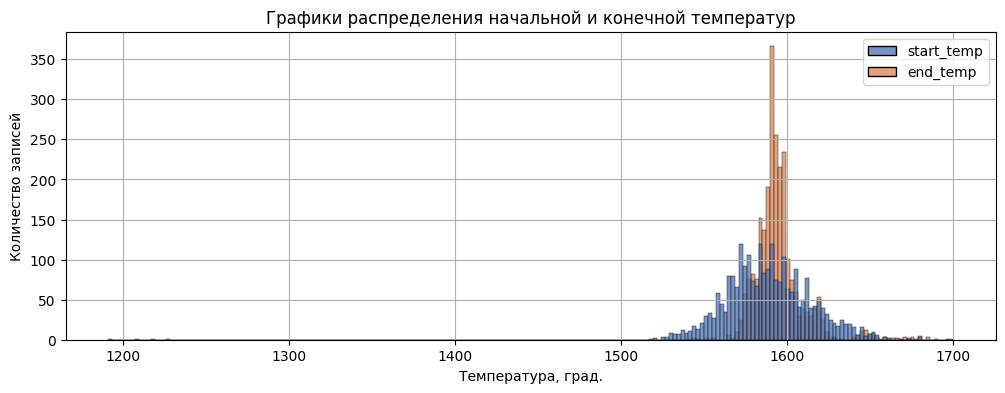

In [75]:
# графики распределения начальной и конечной температур
plt.figure(figsize=(12,4))
sns.histplot(data=data_temp_new[['start_temp', 'end_temp']])
plt.grid()
plt.title('Графики распределения начальной и конечной температур')
plt.xlabel('Температура, град.')
plt.ylabel('Количество записей')
plt.show();

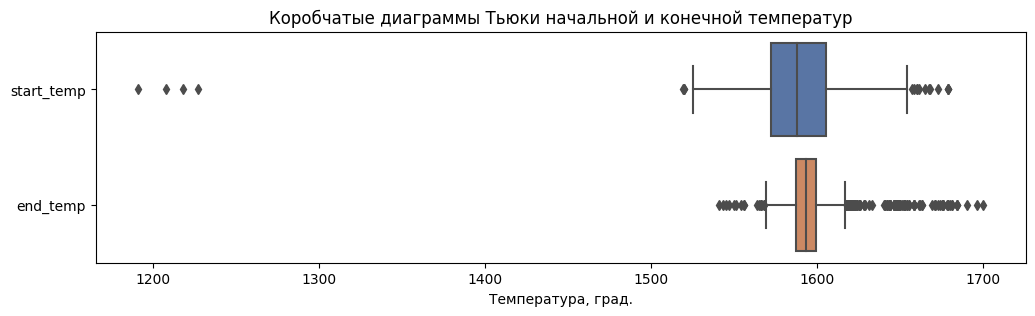

In [76]:
# построим коробчатые диаграммы для начльных и конечных температур
plt.figure(figsize=(12,3))
sns.boxplot(data=data_temp_new[['start_temp', 'end_temp']], orient='horizontal')
plt.title('Коробчатые диаграммы Тьюки начальной и конечной температур')
plt.xlabel('Температура, град.')
plt.show();

Из графика распределения и коробчатых диаграмм видно:
- `медианное значение` **начальной температуры** немного **ниже конечной** и составляет около **1580 гр.**;
- `межквартильный размах` **начальной температуры** намного больше, чем у **конечной температуры**, что говорит о большей вариабельности;
- у обоих температур есть **выбросы**, но у **начальной температуры** есть аномально низкие значения в районе **1200 - 1235 гр.**. По условиям задачи такие температуры аномальны ('Заказчик предупредил, что значения температуры ниже 1500 градусов — аномальные'). Удалим партии с тикими аномальными температурами.

In [77]:
# оставим записи, где начальная температура больше и равна 1500 градусов
data_temp_new = data_temp_new.query('start_temp >= 1500')

**Вывод**:
- загружены данные с базы данных **PostgreSQL** - 7 таблиц. Для удобства таблицы были сохранены в отдельные файлы формата `'.csv'`;
- проведен анализ всех таблиц (проверено наличие пропусков и аномалий с последующей их обработкой, изучены распределения признаков, построены наглядные графики);
- на основе имеющихся данных построены дополнительные признаки (агреггированные, производные, временные);
- данные объеденены в итоговую таблицу. Для объединенния использован метод `'inner'`. Таким образом в итоговую таблицу попали только те партии, для которых во всех таблицах есть данные. Исключены признаки, содержащие даты;
- проведен корреляционный анализ признаков, включая целевой.

Из интересных особенностей на этапе **EDA-исследования** выявлено следующее:
- чаще всего на одну партию приходится от **4 до 5 этапов нагрева**;
- есть партии, требующие так же либо меньшего количества этапов (**от 1 до 3**) или намного большего (**от 6 до 15**);
- `активная` и `реактивная` мощности **сильно положительно коррелируют**;
- в среднем `реактивная мощность` составляет порядка **0.7-0.8** от `активной мощности`;
- `медианнаяя` длительность одного этапа нагрева составляет - **2 мин. 27 сек**;
- есть партии, которые имеют отрицательную длительность между этапами. После просмотра многих партий выявлена та же самая ошибка в данных, связанная с тем, что не всегда после полуночи дата указана с учетом следующих суток;
- `'среднее'` значение объема газа, используемого для продувки сплава составляет **11**, `'медианное'` немного меньше - **9.8**. Видимо для некоторых партий используется больший объем газа для продувки;
- `межквартильный размах` значений объема подаваемого газа - **от 0 до 24**;
- в некторых партиях используется больший объем газа вплоть до **78**;
- не все типы `проволочных` и `сыпучих` материалов добавляются в сталь. Из `сыпучих` материалов чаще всего используются материалы **№14, №12, №15**. Реже - **№3, №4, №6**. Остальные практически не используются. Из `проволочных` материалов чаще всего используются материалы **№1, №2**. Остальные практически не используются. 
- `медианное значение` **начальной температуры** нагрева немного **ниже конечной** и составляет около **1580 гр.**;
- `межквартильный размах` **начальной температуры** намного больше, чем у **конечной температуры**, что говорит о большей вариабельности;
- у обоих температур есть **выбросы**, но у **начальной температуры** есть аномально низкие значения в районе **1200 - 1235 гр.**. По условиям задачи такие температуры аномальны ('Заказчик предупредил, что значения температуры ниже 1500 градусов — аномальные'). Удалим партии с тикими аномальными температурами.

### Подготовка данных к обучению моделей

Объеденим все обработанные данные в один итоговый датафрейм. В него войдут только те партии, по которым представлена вся информация на каждом из этапов плавления сплава, так как каждая партия проходит все этапы подготовки и отсутствие записи на каком-либо этапе свидетелствует скорее об утере информации, а не об исключении партии из данного этапа и, соответственно, может негативно отразиться на качестве модели.

Для объединенния будет использован метод `'inner'`. Таким образом в итоговую таблицу попадут только те партии, для которых во всех таблицах есть данные.

In [78]:
# объединим все таблицы в одну 
df = data_temp_new.join([data_arc_new, data_bulk, data_bulk_time, data_gas, data_wire, data_wire_time], how='inner')
# выведем первые и последние записи итоговой таблицы
df

,start_time_temp,end_time_temp,start_temp,end_temp,start_time_arc,end_time_arc,active_power,reactive_power,heat_count,heat_time_cum,...,wire_5,wire_6,wire_7,wire_8,wire_9,sum_wire,count_wire,start_time_wire,end_time_wire,wire_time
key,,,,,,,,,,,,,,,,,,,,,
1,2023-10-01 11:16:18,2023-10-01 11:30:39,1571.0,1613.0,2023-10-01 11:02:14,2023-10-01 11:28:37,0.975629,0.636648,5,1098,...,0.0,0.0,0.0,0.0,0.0,60.059998,1,2023-10-01 11:11:41,2023-10-01 11:11:41,0
2,2023-10-01 11:37:27,2023-10-01 11:59:12,1581.0,1602.0,2023-10-01 11:34:14,2023-10-01 11:53:18,0.763150,0.499528,4,811,...,0.0,0.0,0.0,0.0,0.0,96.052315,1,2023-10-01 11:46:10,2023-10-01 11:46:10,0
3,2023-10-01 12:13:17,2023-10-01 12:34:57,1596.0,1599.0,2023-10-01 12:06:54,2023-10-01 12:32:19,0.505176,0.319815,5,655,...,0.0,0.0,0.0,0.0,0.0,91.160157,1,2023-10-01 12:13:47,2023-10-01 12:13:47,0
4,2023-10-01 12:52:57,2023-10-01 12:59:25,1601.0,1625.0,2023-10-01 12:39:37,2023-10-01 12:57:50,0.802313,0.515074,4,741,...,0.0,0.0,0.0,0.0,0.0,89.063515,1,2023-10-01 12:48:05,2023-10-01 12:48:05,0
5,2023-10-01 13:23:19,2023-10-01 13:36:01,1576.0,1602.0,2023-10-01 13:11:13,2023-10-01 13:33:55,0.836793,0.563161,4,869,...,0.0,0.0,0.0,0.0,0.0,98.352796,2,2023-10-01 13:18:15,2023-10-01 13:32:06,831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2023-10-01 00:35:45,2023-10-01 00:54:42,1570.0,1591.0,2023-10-01 00:31:05,2023-10-01 00:51:13,0.802673,0.590194,4,723,...,0.0,0.0,0.0,0.0,0.0,89.150879,1,2023-10-01 00:36:13,2023-10-01 00:36:13,0
2496,2023-10-01 01:02:54,2023-10-01 01:29:52,1554.0,1591.0,2023-10-01 01:00:06,2023-10-01 01:23:32,0.700511,0.468364,6,940,...,0.0,0.0,0.0,0.0,0.0,114.179527,1,2023-10-01 01:13:33,2023-10-01 01:13:33,0
2497,2023-10-01 01:41:53,2023-10-01 01:53:50,1571.0,1589.0,2023-10-01 01:38:01,2023-10-01 01:50:45,0.737460,0.617090,3,569,...,0.0,0.0,0.0,0.0,0.0,103.134723,2,2023-10-01 01:42:27,2023-10-01 01:42:51,24


Удалим все признаки с датами из итоговой таблицы.

In [79]:
# определим список колонок, содержащих даты
date_cols = df.select_dtypes('datetime').columns
# выведем список
date_cols

Index(['start_time_temp', 'end_time_temp', 'start_time_arc', 'end_time_arc',
       'start_time_bulk', 'end_time_bulk', 'start_time_wire', 'end_time_wire'],
      dtype='object')

In [80]:
# удалим колонки с датами
df.drop(date_cols, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2499
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   start_temp        2325 non-null   float64
 1   end_temp          2325 non-null   float64
 2   active_power      2325 non-null   float64
 3   reactive_power    2325 non-null   float64
 4   heat_count        2325 non-null   int64  
 5   heat_time_cum     2325 non-null   int32  
 6   time_between_cum  2325 non-null   int32  
 7   break_ratio_cum   2325 non-null   float64
 8   power_cum         2325 non-null   float64
 9   energy_cum        2325 non-null   float64
 10  bulk_1            2325 non-null   float64
 11  bulk_2            2325 non-null   float64
 12  bulk_3            2325 non-null   float64
 13  bulk_4            2325 non-null   float64
 14  bulk_5            2325 non-null   float64
 15  bulk_6            2325 non-null   float64
 16  bulk_7            2325 non-null   float64


Выведем графики распределения по всем итоговым признакам.

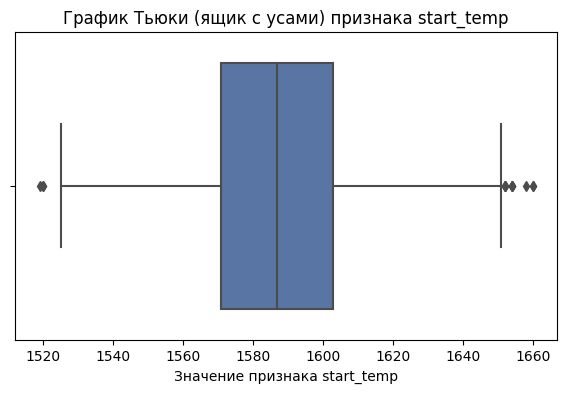

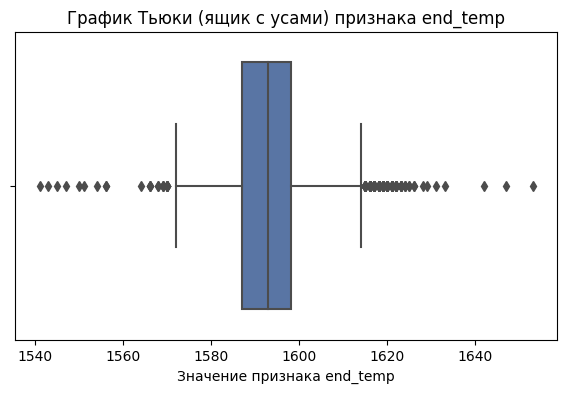

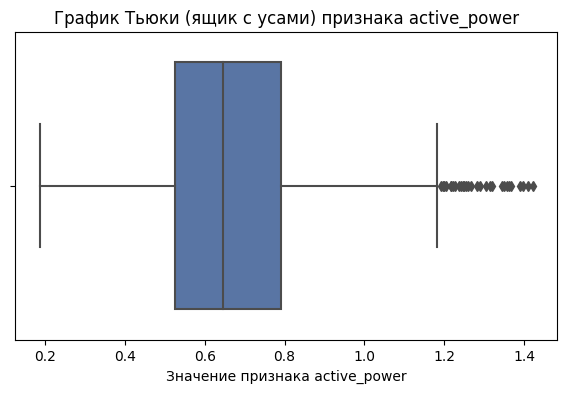

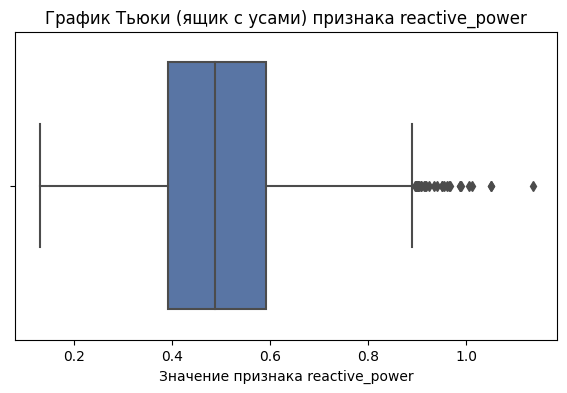

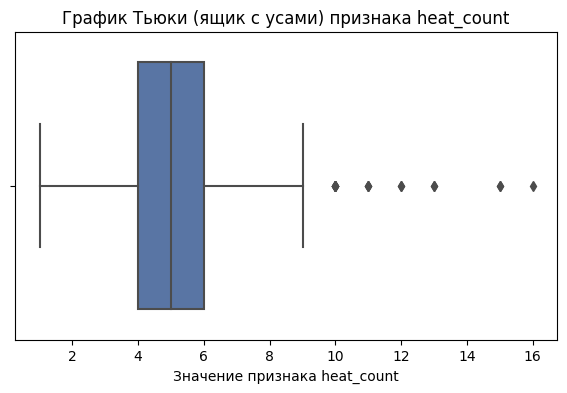

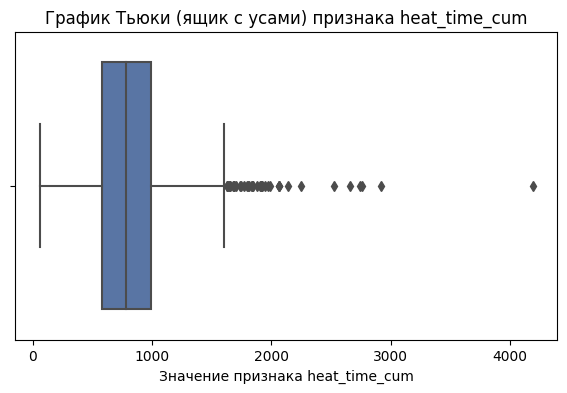

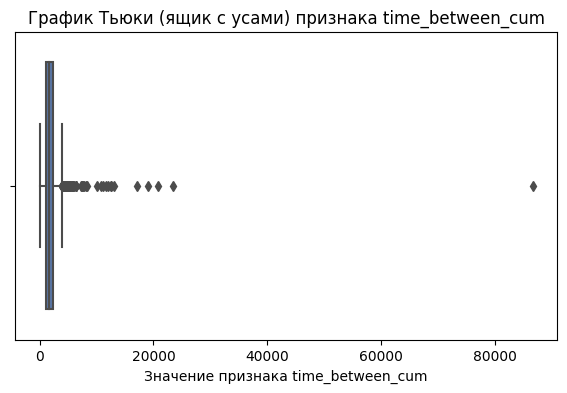

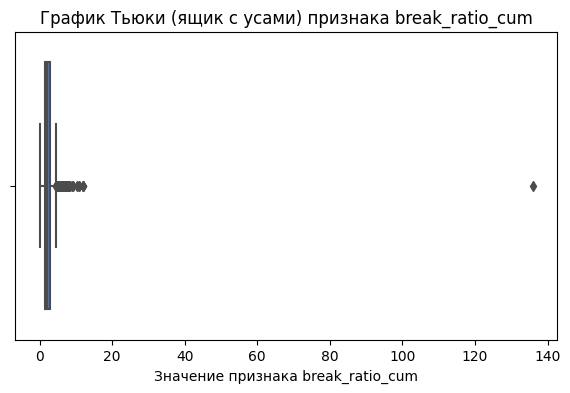

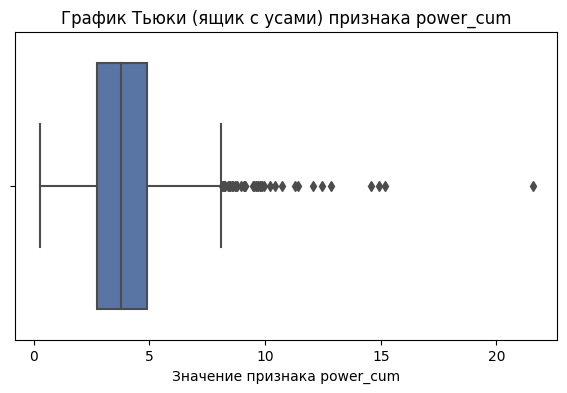

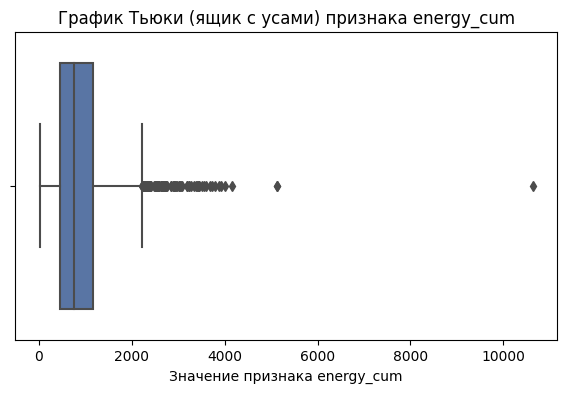

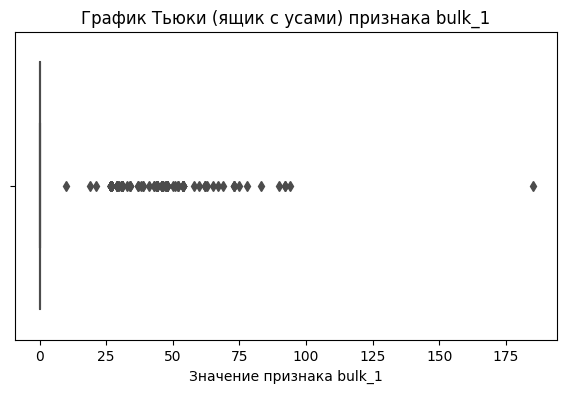

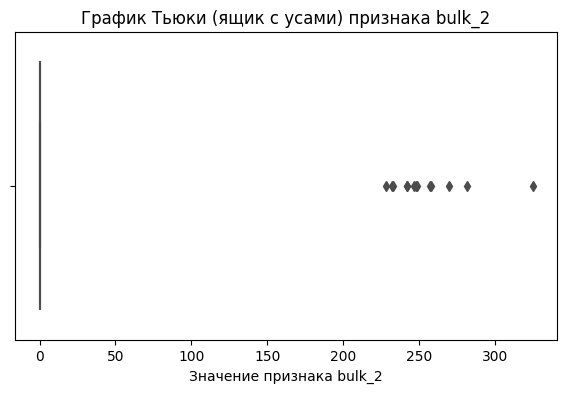

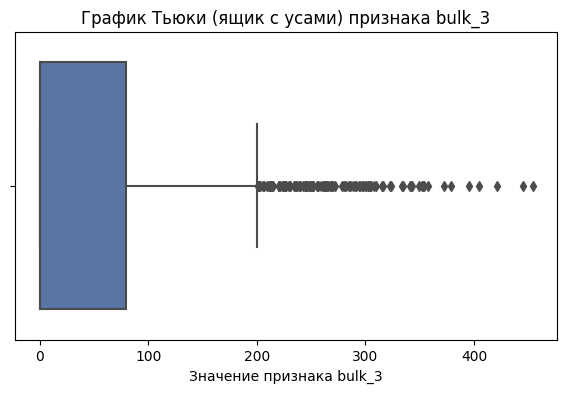

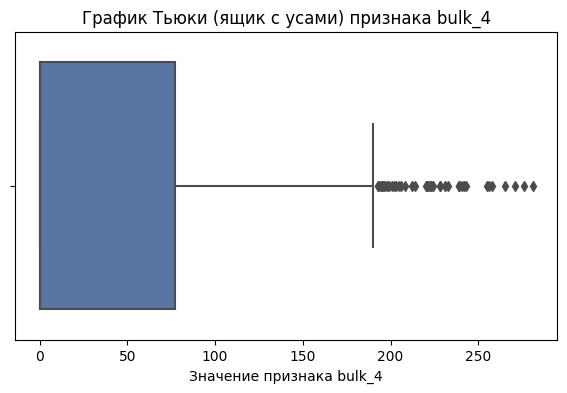

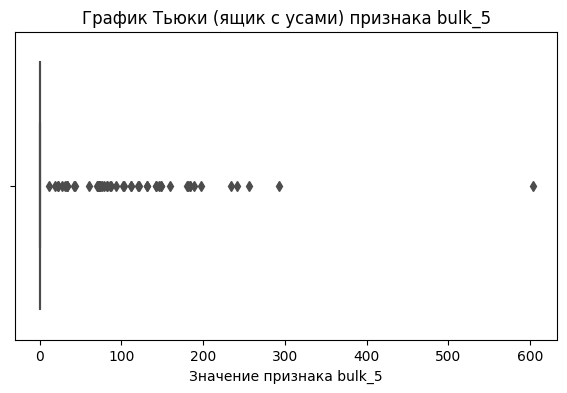

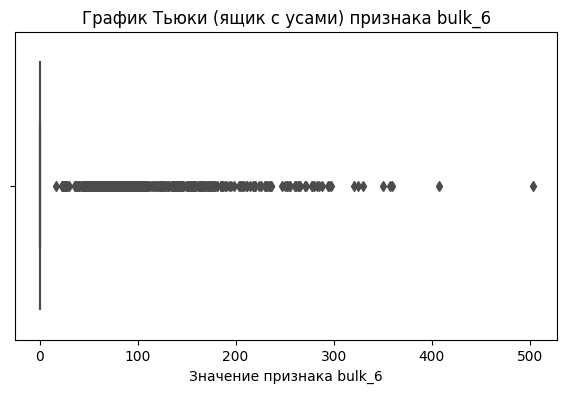

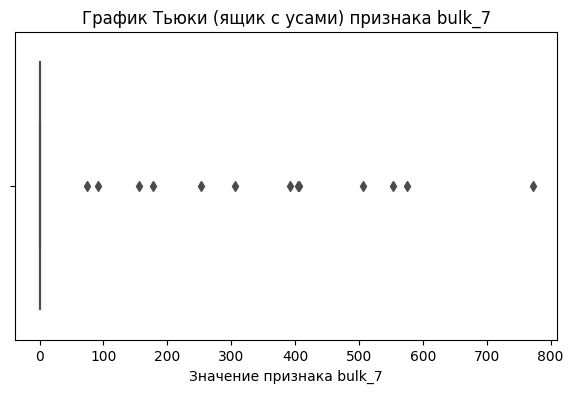

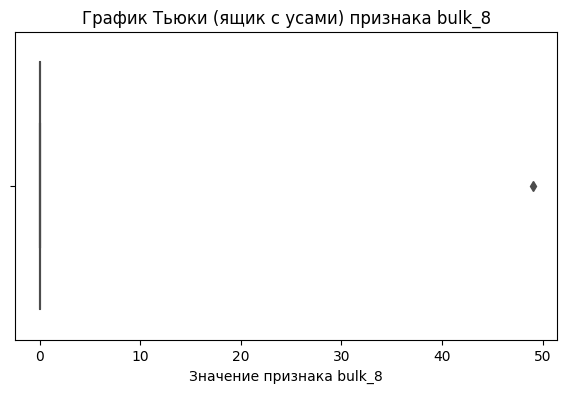

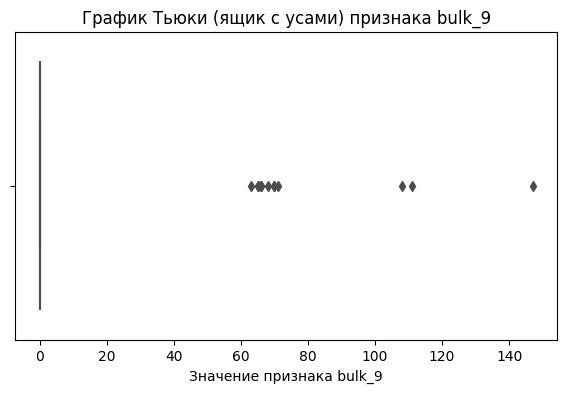

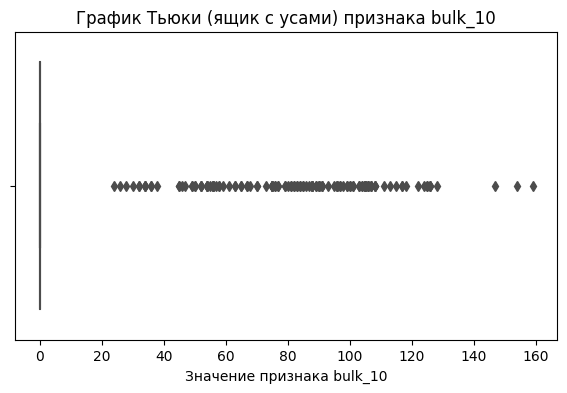

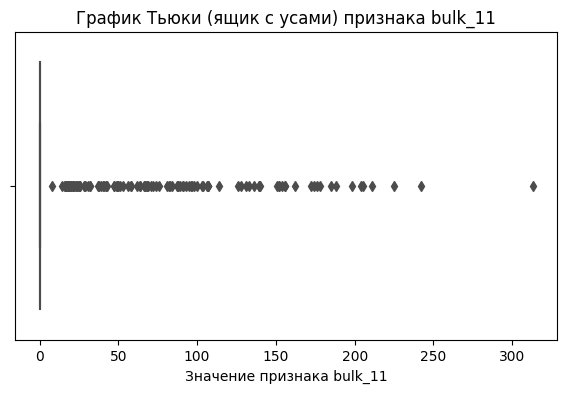

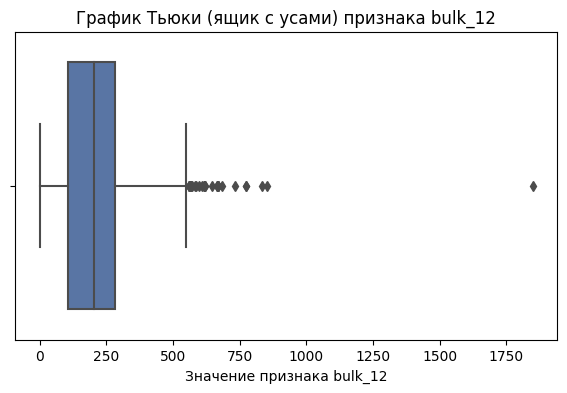

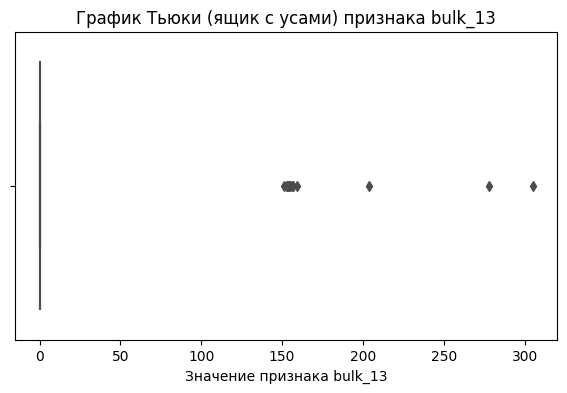

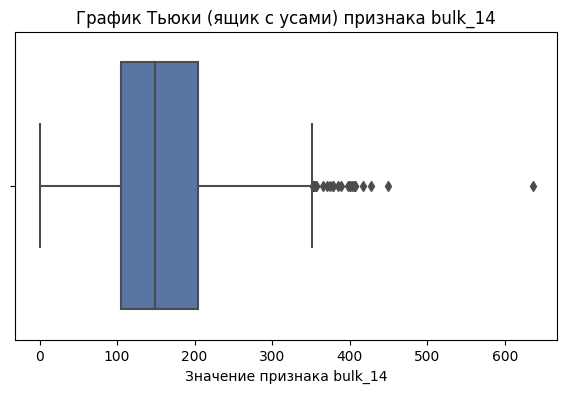

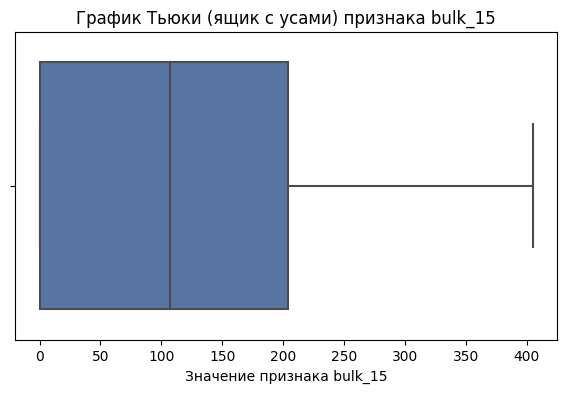

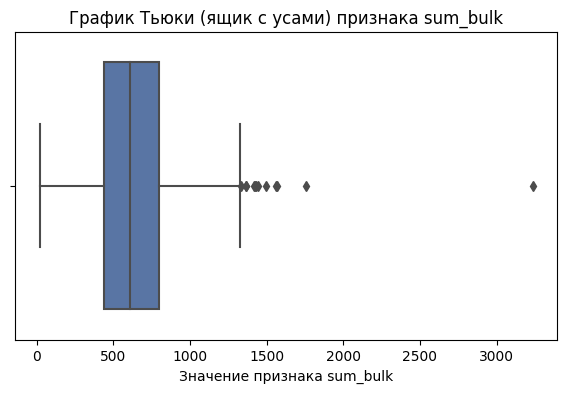

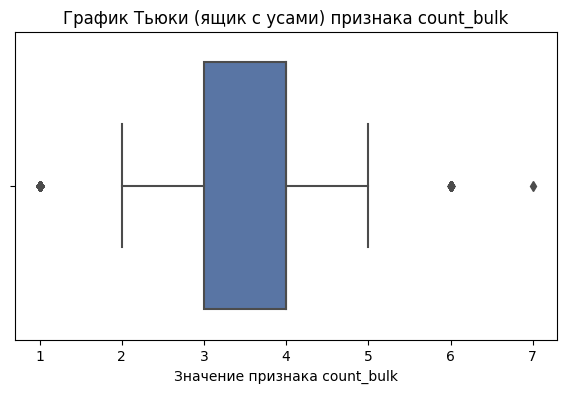

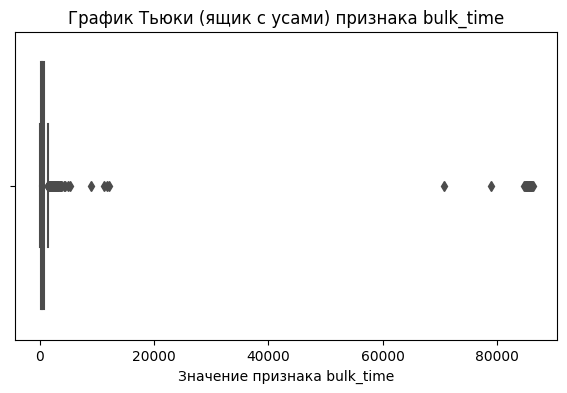

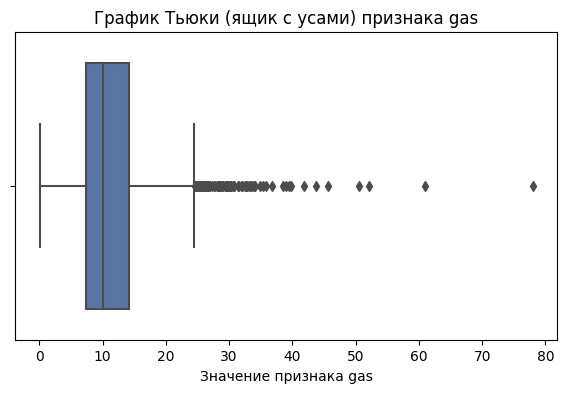

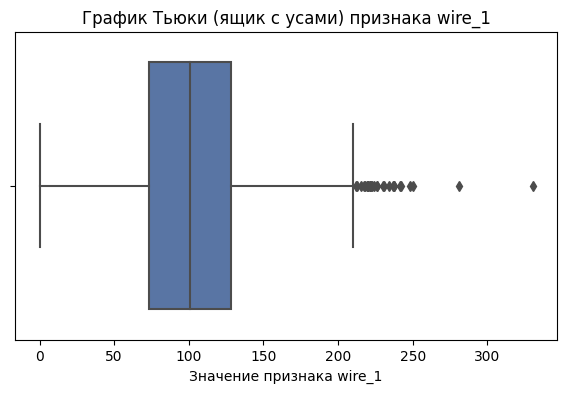

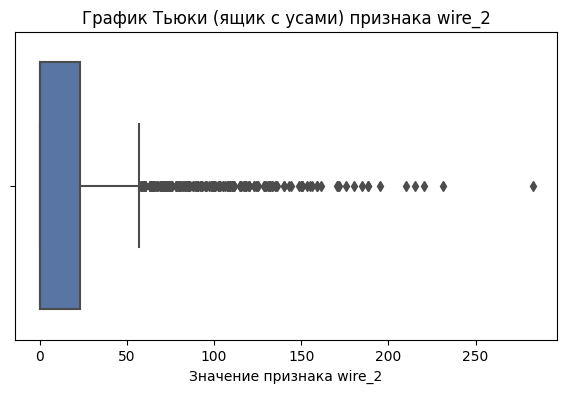

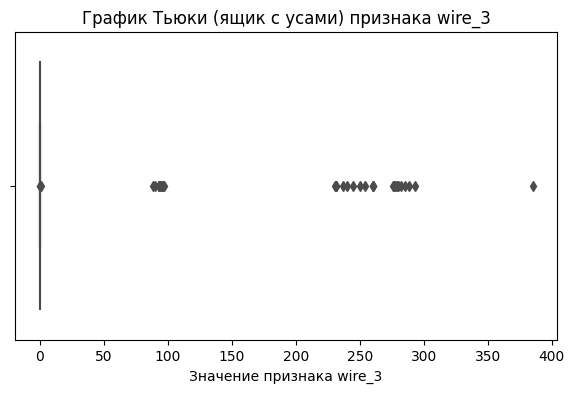

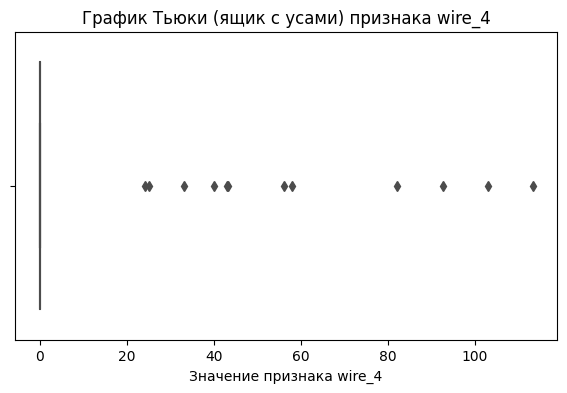

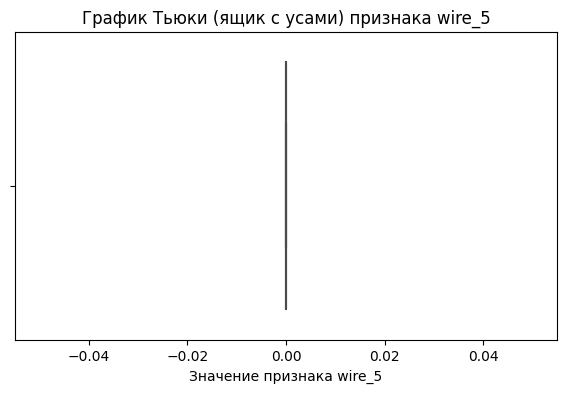

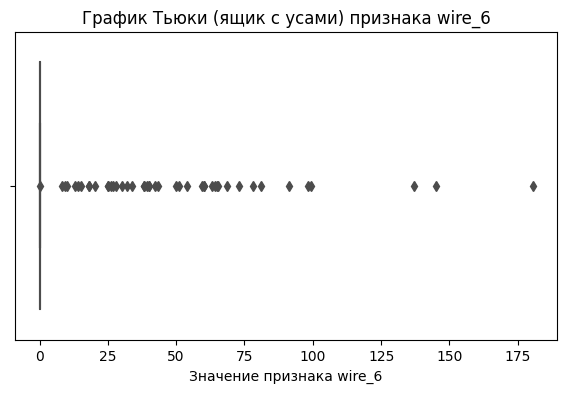

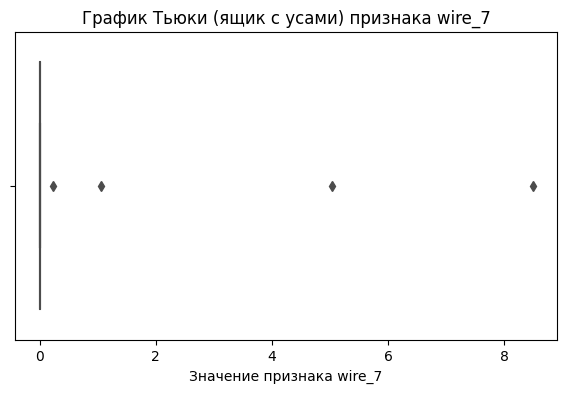

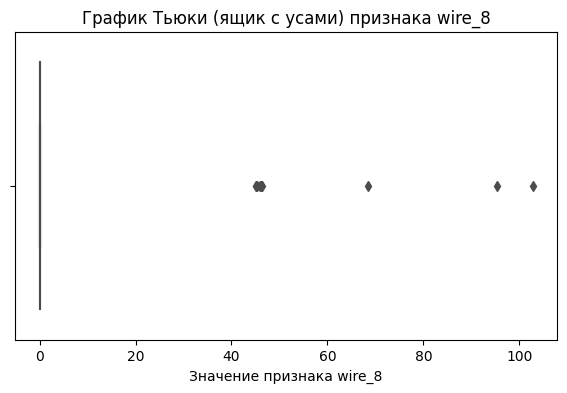

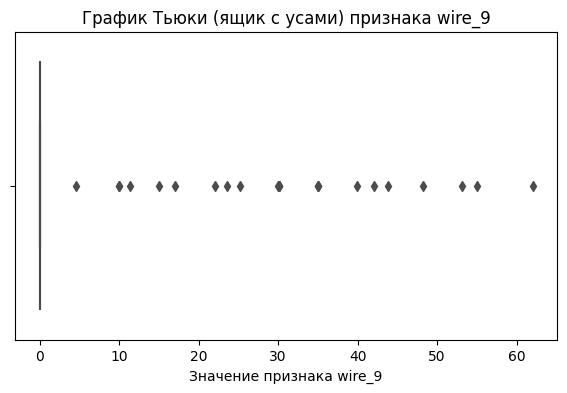

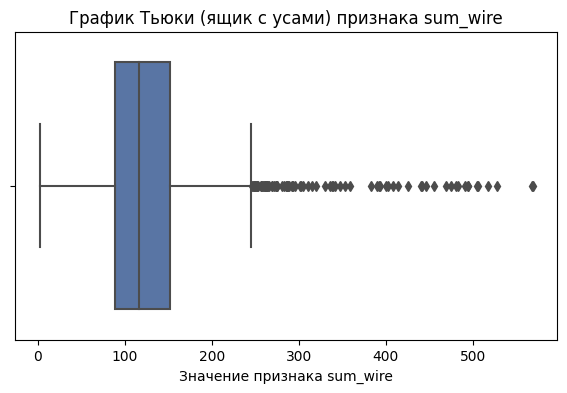

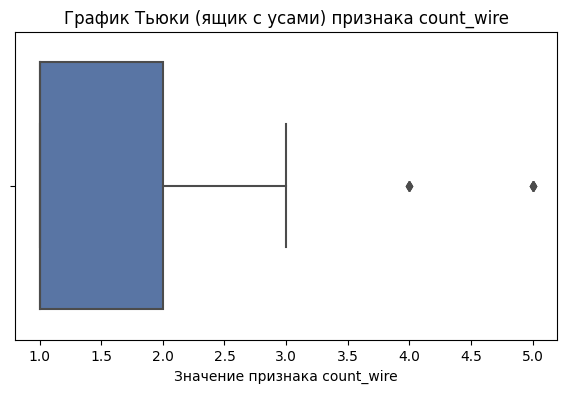

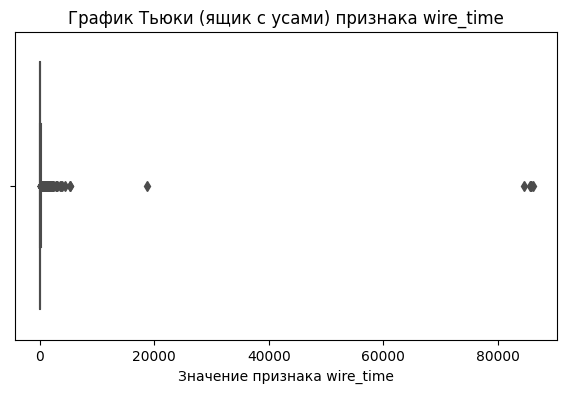

In [81]:
# напишем функцию для вывода графиков Тьюки по каждому признаку в итоговой таблице
def features_boxplot(features: list):

    '''Функция выодит графики Тьюки (boxplots) для каждого признака из переданного списка'''
    for feat in features:
        plt.figure(figsize=(7, 4))
        sns.boxplot(data=df, x=feat)
        plt.title(f'График Тьюки (ящик с усами) признака {feat}')
        plt.xlabel(f'Значение признака {feat}')
        plt.show();
# вызовем функцию для отображения графиков
features_boxplot(df.columns)

Из графика Тьюки видно, что признак `wire_5` имеет единственное значение и бесполезен для обучения моделей, исключим его из даных.

In [82]:
df.drop('wire_5', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2499
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   start_temp        2325 non-null   float64
 1   end_temp          2325 non-null   float64
 2   active_power      2325 non-null   float64
 3   reactive_power    2325 non-null   float64
 4   heat_count        2325 non-null   int64  
 5   heat_time_cum     2325 non-null   int32  
 6   time_between_cum  2325 non-null   int32  
 7   break_ratio_cum   2325 non-null   float64
 8   power_cum         2325 non-null   float64
 9   energy_cum        2325 non-null   float64
 10  bulk_1            2325 non-null   float64
 11  bulk_2            2325 non-null   float64
 12  bulk_3            2325 non-null   float64
 13  bulk_4            2325 non-null   float64
 14  bulk_5            2325 non-null   float64
 15  bulk_6            2325 non-null   float64
 16  bulk_7            2325 non-null   float64


**Вывод:**
- все данные объединены в итоговую таблицу. Всего получилось **2325 наблюдений**, **39 независимых** и **1 целевой признак**;
- уалены все признаки содержащие **даты**;
- на `графиках Тьюки` ('ящики с усами'), хорошо видно, что практически у каждого признака есть выборы. Это может повлиять на качество моделей ввиду шумности в данных, но так как итоговый объем выборки небольшой, оставим все данные в таком виде.

### Корреляция между признаками и целевым признаком

Построим диаганальную матрицу корреляции между признаками с ранговым коэффициентом **Спирмена**.

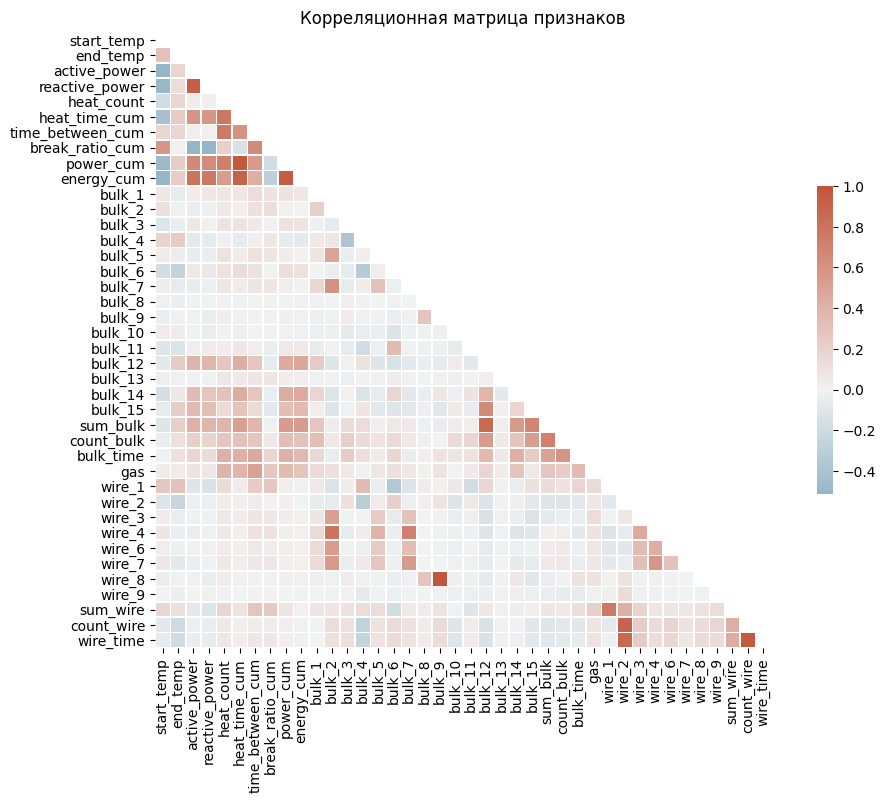

In [83]:
corr = df.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(230, 20, as_cmap=True), 
            vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Корреляционная матрица признаков')
plt.show();

Согласно корреляционной матрицы:
- наблюдается **сильная положительная линейная связь** между `реактивной мощностью` и `активной мощностью.` На этапе EDA было обнаружено что в среднем `реактивная мощность` составляет **0.75** от `активной мощности`;
- наблюдается **сильная положительная линейная связь** между `суммарным временем нагрева`, `реактивной мощностью`,  `активной мощностью` и `суммарным количеством этапов нагрева`, что физически вполне закономерно;
- наблюдается **сильная положительная линейная связь** между `суммарным временем между началами этапов нагрева`, `суммарным количеством этапов нагрева` и `суммарным временем нагрева`, так как первая компонента включает в себя все остальные. Возможно необходимо будет исключить один из признаков во избежжание **мультиколлинеарности**;
- наблюдается **достаточно положительная линейная связь** между `отношением времени нагрева к обшему времени между этапами`, `начальной температурой` и `суммарным временем между началами этапов нагрева`;
- наблюдается **сильная положительная линейная связь** между `суммарным мощностью нагрева`, `активной мощностью`, `реактивной мощностью`, `суммарным временем нагрева`, `суммарным количеством этапов нагрева` и `суммарным временем между началами этапов нагрева`, так как первая компонента включает в себя все остальные или является производной от них. Возможно необходимо будет исключить один из признаков во избежжание **мультиколлинеарности**;
- наблюдается **сильная положительная линейная связь** между `суммарной энергией нагрева`, `активной мощностью`, `реактивной мощностью`, `суммарным временем нагрева`, `суммарным количеством этапов нагрева`, `суммарным временем между началами этапов нагрева` и `суммарным мощностью нагрева`, так как первая компонента включает в себя все остальные или является производной от них. Возможно необходимо будет исключить один из признаков во избежжание **мультиколлинеарности**;
- среди `проволочных` и `сыпучих` материалов так же наблюдается **достаточно положительная линейная связь**,  а в каких-то случаях и **небольшая отрицательная линейная связь**, что говорит о том, что при добавлении одних типов материалов добавляются/либо наоборот не добавляются другие.

Теперь отдельно посмортим как коррелируют признаки с целевой переменной `'end_temp'` (конечная температура).

C:\Users\Artem\AppData\Local\Temp\ipykernel_18420\1086964275.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  corr_with_target = pd.Series()


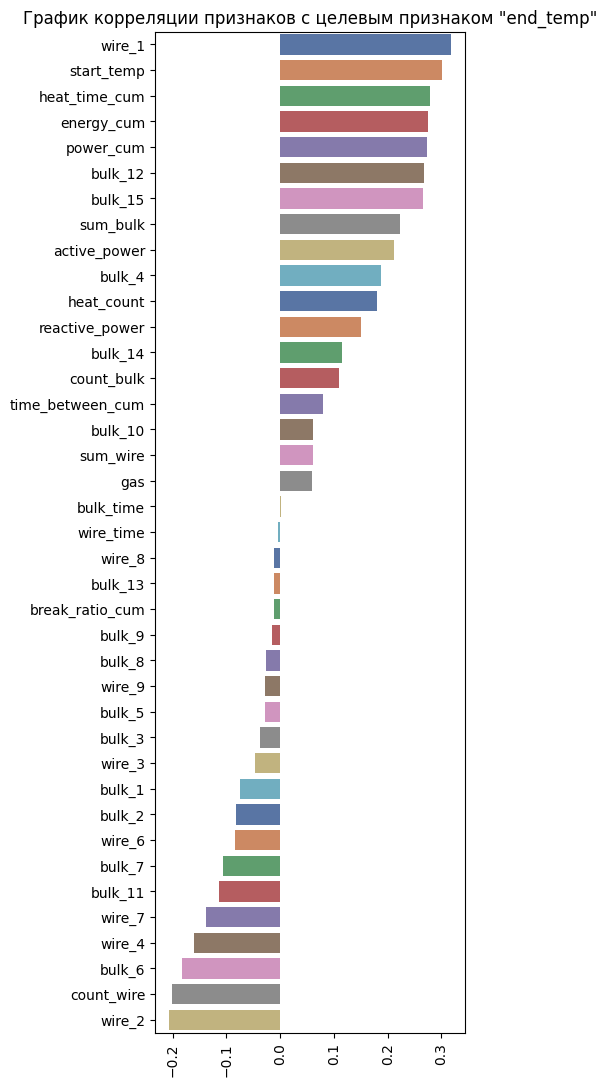

In [84]:
# для каждого признака расчитаем корреляцию с целевым признаком
corr_with_target = pd.Series()
for col in df.columns:
    corr_with_target[col] = df['end_temp'].corr(df[col])
# отсортируем значения в порядке убывания
corr_with_target = corr_with_target.sort_values(ascending=False)[1:]
# построим столбчатую диаграмму корреляции 
plt.figure(figsize=(4,13))
sns.barplot(y=corr_with_target.index, x=corr_with_target.values, palette='deep')
plt.title('График корреляции признаков с целевым признаком "end_temp"')
plt.xticks(rotation=90)
plt.show();

Между `типом проволочных материалов wire_1` и `окончательной температурой`, а так же `начальной температурой` и `окончательной температурой` есть **очень слабая положительная линейная связь**. 

### Разделение данных на обучающую и валидационную выборки

Разделим итоговые данные на `обучающую` и `тестовую (отложенную)` выборки, (`test_size = 0.25`). В связи с небольшим количеством доступных данных в качестве `валидационной выборки` будет использоваться кросс-валидация на 5-и фолдах.

In [85]:
# создадим отдельные датафреймы для независимых признакв и целевой зависимой переменной X и y 
X = df.drop('end_temp', axis=1)
y = df['end_temp']

# разделим выборку на train и test в соотношении 75/25 %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND_ST)

# выведем размерности полученных  выборок
print('Размерность обучающей выборки', X_train.shape, y_train.shape)
print('Размерность тестовой выборки', X_test.shape, y_test.shape)

Размерность обучающей выборки (1743, 39) (1743,)
Размерность тестовой выборки (582, 39) (582,)


## Обучение моделей

### Константная модель Baseline 

Для оценки построенных далее моделей на "адекватность", необходимо понять, какой уровень качества дает **константная бейзлайн-модель**, основанная на стратегии **среднего значения**.

In [86]:
# создадим регрессионную Dummy модель
dummy_reg = DummyRegressor(strategy='mean')
# обучим модель
dummy_reg.fit(X_train, y_train)
# сделаем предсказание на тестовой выборке
dummy_pred = dummy_reg.predict(X_test)

# расчитаем метрик: MAE
dummy_mae = mean_absolute_error(y_test, dummy_pred)
print("Dummy MAE:", dummy_mae)

Dummy MAE: 8.529123859207072


### Линейные модели (Lasso и Ridge)

#### Lasso

In [87]:
# создадим Pipeline
pipe_lasso = make_pipeline(
    StandardScaler(),
    Lasso(random_state=RAND_ST)
)

# зададим параметры для поиска с помощью GridSearchCV
param_grid = {
    'lasso__alpha': np.linspace(0, 1, 100)
}

# параметры GridSearch
grid_lasso = GridSearchCV(
    pipe_lasso,
    param_grid,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5
)

In [88]:
%%time 

# обучим модель с поиском наилучших гиперпараметров и кросс-валидации на 5-и фолдах
grid_lasso.fit(X_train, y_train)

CPU times: total: 203 ms
Wall time: 3.14 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lasso', Lasso(random_state=210923))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.1717171...
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747475,
       0.75757576, 0.76767677, 0.77777778, 0.78787879, 0.7979798 ,
       0.80808081, 0.81818182, 0.82828283, 0.83838384, 0.84848485,
       0.85858586, 0.86868687, 0.87878788, 0.88888889, 0.8989899 ,
       0.90909091, 0.91919192, 0.92929293, 0.93939394, 0.94949495,
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ])},
             scoring='neg_mean_absolute_error')

In [89]:
# сохраним результаты в общую таблицу и выведем метрику качества MAE на валидационной выборке
model_lasso_mae = abs(grid_lasso.best_score_)
models_val_mae_res = [model_lasso_mae]
print('Гиперпараметры лучшей модели:', grid_lasso.best_params_)
print('MAE на кросс-валидации:', model_lasso_mae)

Гиперпараметры лучшей модели: {'lasso__alpha': 0.030303030303030304}
MAE на кросс-валидации: 5.56372084327444


In [90]:
def features_importances_plot(features_importances, features_names, model_name):

    '''Функция принимающая на вход значения важности признаков для модели,
    названия признаков и наименование модели. На основе переданных данных
    функция выводит график значимости признаков.'''
    
    feat_importances = pd.Series(features_importances, index=features_names).sort_values(ascending=False)
    plt.figure(figsize=(15,5))
    sns.barplot(x=feat_importances.index, y=feat_importances.values,  palette='deep')
    plt.title(f'График значимости признаков для модели {model_name}')
    plt.xticks(rotation=90);

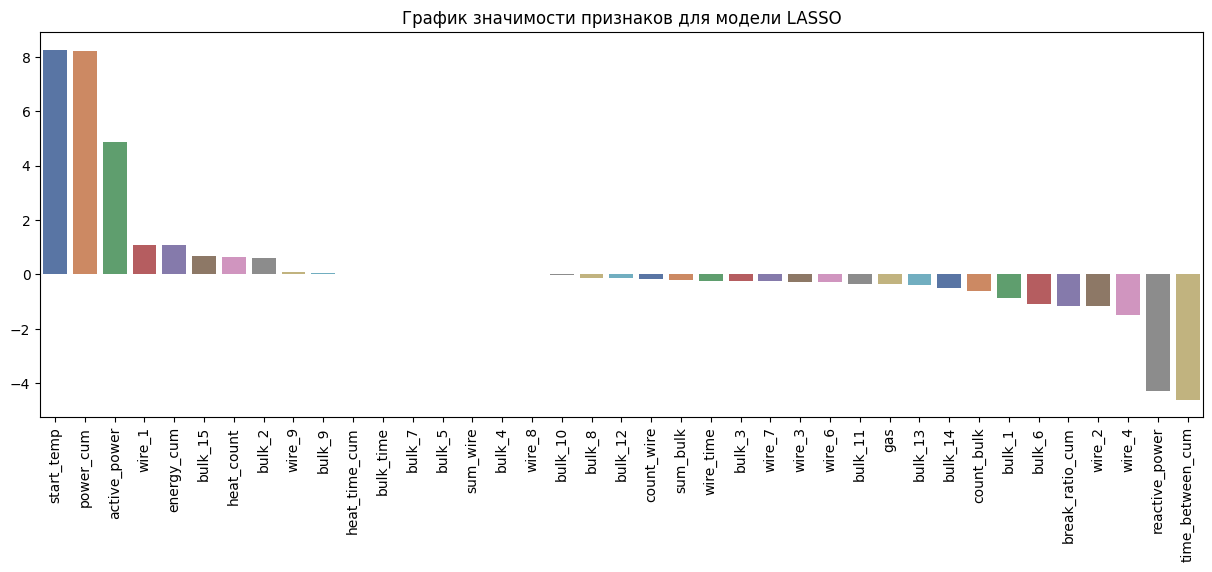

In [91]:
# пострроим график значимости признаков для модели Lasso
features_importances_plot(grid_lasso.best_estimator_.named_steps.lasso.coef_, X_train.columns, model_name='LASSO')

- наибольший вес линейной модели **Lasso** с **L1-регуляризацией**  имеет признак `'start_temp'` ('начальная температура нагрева') и `'power_cum'` ('суммарная мощность нагрева');
- такие признаки как `'active_power'`, `'reactive_power'`, `'time_between_cum'` менее, но все же **значимы** для модели. Причем признаки `'time_between_cum'` и `'reactive_power'` имеют значимость с обратной зависимостью, т.е. например можно сказать, что чем больше `время между двумя этапами нагрева` тем меньше `конечная температура`; 
- обнулились коэффициенты при некоторых `сыпучих` и `проволочных материалах`, их `суммы`. 

#### Ridge

In [92]:
# создадим Pipeline
pipe_ridge = make_pipeline(
    StandardScaler(),
    Ridge(random_state=RAND_ST)
)

# зададим параметры для поиска с помощью GridSearchCV
param_grid = {
    'ridge__alpha': np.linspace(0, 1, 100),
    'ridge__solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# параметры GridSearch
grid_ridge = GridSearchCV(
    pipe_ridge,
    param_grid,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5
)

In [93]:
%%time 

# обучим модель с поиском наилучших гиперпараметров и кросс-валидации на 5-и фолдах
grid_ridge.fit(X_train, y_train)

CPU times: total: 2.22 s
Wall time: 18.3 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge(random_state=210923))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.1717171...
       0.75757576, 0.76767677, 0.77777778, 0.78787879, 0.7979798 ,
       0.80808081, 0.81818182, 0.82828283, 0.83838384, 0.84848485,
       0.85858586, 0.86868687, 0.87878788, 0.88888889, 0.8989899 ,
       0.90909091, 0.91919192, 0.92929293, 0.93939394, 0.94949495,
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ]),
                         'ridge__solver': ['svd', 'cholesky', 'lsqr',
                                           'sparse_cg', 'sag', 'saga']},
             scoring='neg_mean_abs

In [94]:
# сохраним результаты в общую таблицу и выведем метрику качества MAE на валидационной выборке
model_ridge_mae = abs(grid_ridge.best_score_)
models_val_mae_res.append(model_ridge_mae)
print('Гиперпараметры лучшей модели:', grid_ridge.best_params_)
print('MAE на кросс-валидации:', model_ridge_mae)

Гиперпараметры лучшей модели: {'ridge__alpha': 0.9797979797979799, 'ridge__solver': 'saga'}
MAE на кросс-валидации: 5.5830890744743


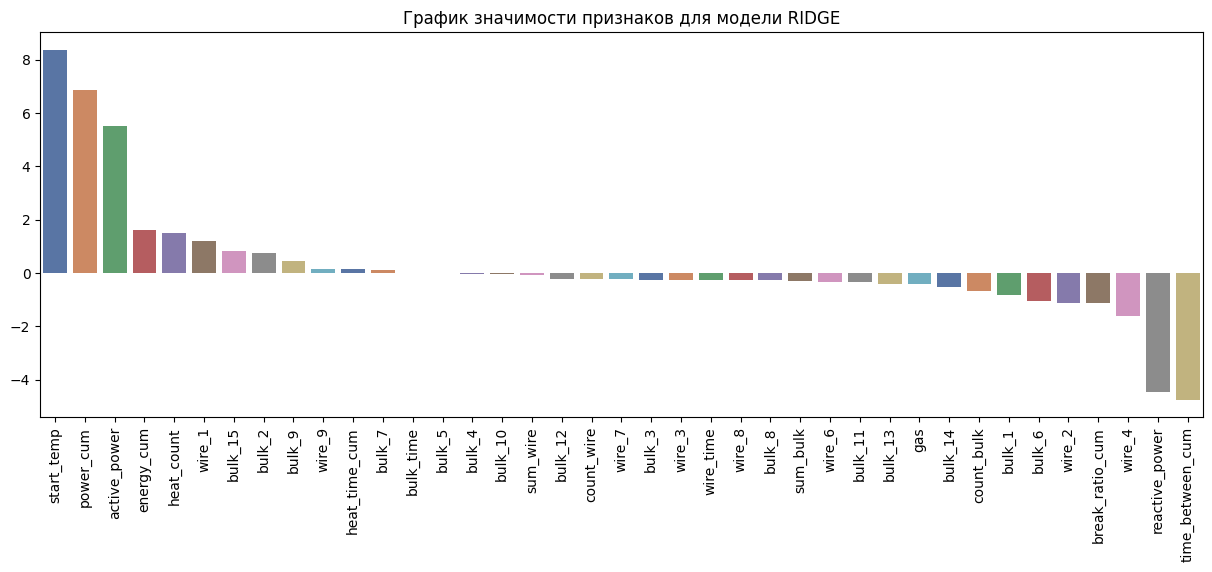

In [95]:
# пострроим график значимости признаков для модели Ridge
features_importances_plot(grid_ridge.best_estimator_.named_steps.ridge.coef_, X_train.columns, model_name='RIDGE')

- наибольший вес линейной модели **Ridge** с **L2-регуляризацией**  имеет так же как и у модели **Lasso** признак `'start_temp'` ('начальная температура нагрева');
- такие признаки как `'power_cum'`, `'active_power'`, `'reactive_power'`, `'time_between_cum'` менее, но все же **значимы** для модели. Причем признаки `'time_between_cum'` (`время между двумя этапами нагрева`) и `'reactive_power'` (`реактивная мощность`) имеют значимость с обратной зависимостью, т.е. можно сказать, что чем выше `время между двумя этапами нагрева` и `реактивная мощность` тем меньше `конечная температура`; 
- обнулился коэффициент при признаке `'bulk_5'` и `'bulk_time'`. Скорее всего он не значим для модели в предсказании целевой переменной.

### Модель RandomForest

In [96]:
# создадим Pipeline
pipe_rf = make_pipeline(
    RandomForestRegressor(random_state=RAND_ST, n_jobs=-1)
)

# зададим параметры для поиска с помощью GridSearchCV
param_grid = {
    'randomforestregressor__n_estimators': [750], # [300, 450, 600, 750, 800],
    'randomforestregressor__max_features': ['auto'], # ['auto', 'sqrt', 'log2'],
    'randomforestregressor__max_depth': [9], # range(2, 10)
}

# параметры GridSearch
grid_rf = GridSearchCV(
    pipe_rf,
    param_grid,
    error_score='raise',
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5
)

In [97]:
%%time 

# обучим модель с поиском наилучших гиперпараметров и кросс-валидации на 5-и фолдах
grid_rf.fit(X_train, y_train)

CPU times: total: 1.06 s
Wall time: 5.14 s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('randomforestregressor',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=210923))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [9],
                         'randomforestregressor__max_features': ['auto'],
                         'randomforestregressor__n_estimators': [750]},
             scoring='neg_mean_absolute_error')

In [98]:
# сохраним результаты в общую таблицу и выведем метрику качества MAE на валидационной выборке
model_rf_mae = abs(grid_rf.best_score_)
models_val_mae_res.append(model_rf_mae)
print('Гиперпараметры лучшей модели:', grid_rf.best_params_)
print('MAE на кросс-валидации:', model_rf_mae)

Гиперпараметры лучшей модели: {'randomforestregressor__max_depth': 9, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__n_estimators': 750}
MAE на кросс-валидации: 5.91559171958413


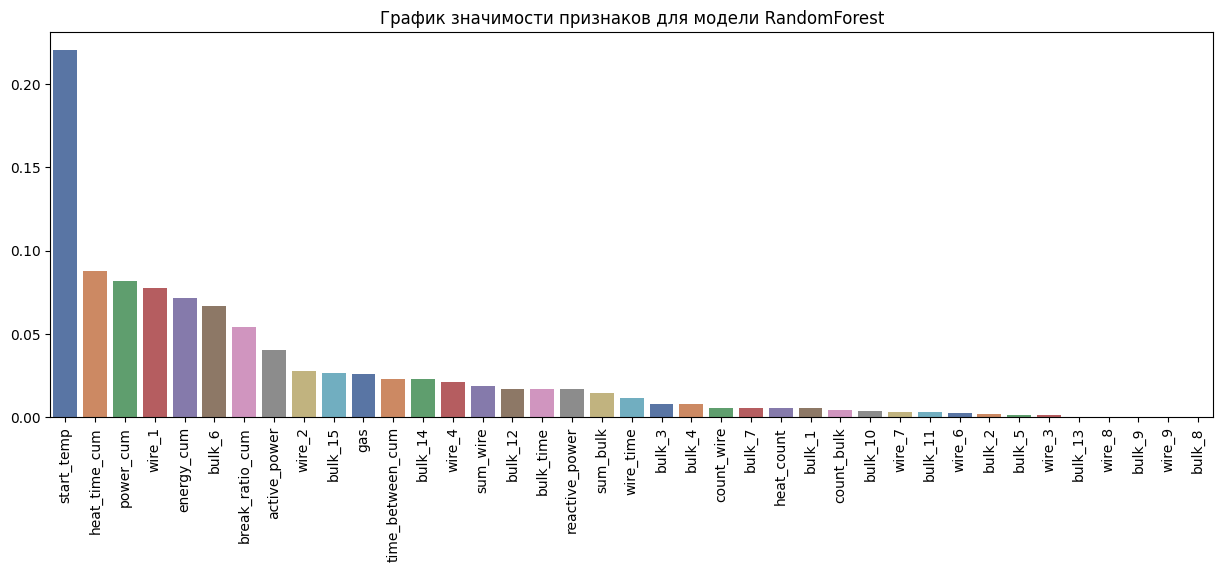

In [99]:
# пострроим график значимости признаков для модели RandomForest
features_importances_plot(grid_rf.best_estimator_.named_steps.randomforestregressor.feature_importances_, X_train.columns, model_name='RandomForest')

- наибольший вес модели случайного леса **RandomForestRegressor** имеет признак `'start_temp'` ('температура на предыдущем этапе'). Отсальные признаки менее значимы и их значисмость плавно убывает.

### Модель LGBMRegressor

In [100]:
# создадим Pipeline
pipe_lgbm = make_pipeline(
    LGBMRegressor(random_state=RAND_ST, n_jobs=-1, verbose=-1)
)

# зададим параметры для поиска с помощью GridSearchCV
param_grid = {
    'lgbmregressor__max_depth': [8], # range(2, 15, 1),
    'lgbmregressor__subsample': [0.5], # np.arange(0.5, 1, 0.1),
    'lgbmregressor__feature_fraction': [0.8], # np.arange(0.1, 1.1, 0.1),
    'lgbmregressor__reg_alpha': [0.25], # np.arange(0, 1, 0.05),
    'lgbmregressor__reg_lambda': [0] # np.arange(0, 10, 1) 
}

# параметры GridSearch
grid_lgbm = GridSearchCV(
    pipe_lgbm,
    param_grid,
    error_score='raise',
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5
)

In [101]:
%%time 

# обучим модель с поиском наилучших гиперпараметров и кросс-валидации на 5-и фолдах
grid_lgbm.fit(X_train, y_train)

CPU times: total: 688 ms
Wall time: 512 ms


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('lgbmregressor',
                                        LGBMRegressor(n_jobs=-1,
                                                      random_state=210923,
                                                      verbose=-1))]),
             n_jobs=-1,
             param_grid={'lgbmregressor__feature_fraction': [0.8],
                         'lgbmregressor__max_depth': [8],
                         'lgbmregressor__reg_alpha': [0.25],
                         'lgbmregressor__reg_lambda': [0],
                         'lgbmregressor__subsample': [0.5]},
             scoring='neg_mean_absolute_error')

In [102]:
# сохраним результаты в общую таблицу и выведем метрику качества MAE на валидационной выборке
model_lgbm_mae = abs(grid_lgbm.best_score_)
models_val_mae_res.append(model_lgbm_mae)
print('Гиперпараметры лучшей модели:', grid_lgbm.best_params_)
print('MAE на кросс-валидации:', model_lgbm_mae)

Гиперпараметры лучшей модели: {'lgbmregressor__feature_fraction': 0.8, 'lgbmregressor__max_depth': 8, 'lgbmregressor__reg_alpha': 0.25, 'lgbmregressor__reg_lambda': 0, 'lgbmregressor__subsample': 0.5}
MAE на кросс-валидации: 5.607919696826495


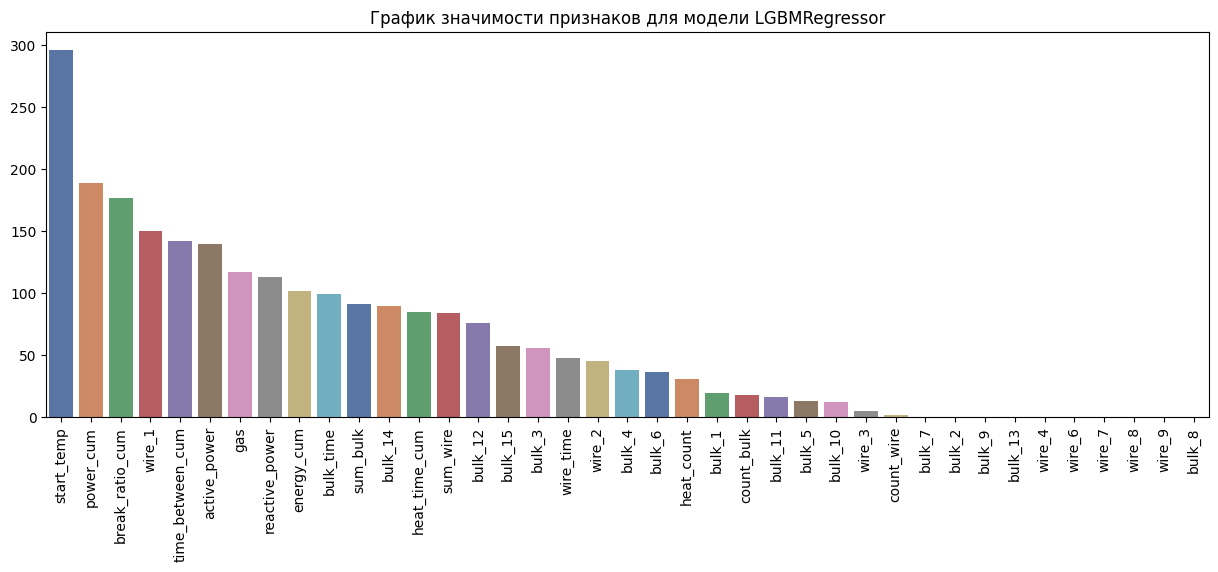

In [103]:
# построим график значимости признаков для модели LGBMRegressor
features_importances_plot(grid_lgbm.best_estimator_.named_steps.lgbmregressor.feature_importances_, X_train.columns, model_name='LGBMRegressor')

- наибольший вес модели случайного слеса **RandomForestRegressor** имеет так же признак `'start_temp'`;
- более половины признаков имеют хорошую 'важность' для модели **LGBMRegressor**, что не скажешь о других моделях;
- в целом модель **LGBMRegressor** опирается на большую часть признаков для предсказания температуры, что может говорить о большем доверии к результатам.

### Нейронная сеть

Построим `полносвязную нейронную сеть` используя **pytorch** и регуляризацию с помощью `BatchNorm` и `Dropout`. Для подбора параметров сети, включая `learning_rate` используем **RandomizedSearchCV**.

In [104]:
torch.manual_seed(RAND_ST)
random.seed(RAND_ST)
np.random.seed(RAND_ST)

# масштабирование выборочной и тестовой выборок
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# объединение и преобразование данных в float torch-тензоры
X_train_sc = X_train_sc.astype(np.float32)
X_test_sc = X_test_sc.astype(np.float32)
y_train_nn = (y_train.values.reshape(-1, 1)).astype(np.float32)
y_test_nn = (y_test.values.reshape(-1, 1)).astype(np.float32)

# вывод размерности полученных данных
print(f'Размер обучающей выборки после объединения признаков: {X_train_sc.shape}')
print(f'Размер тестовой выборки после объединения признаков: {X_test_sc.shape}')
print('-' * 20)

# создание класса нейронной сети
class Net(nn.Module):
    
    def __init__(self, 
                 dropout=0, 
                 bn=False, 
                 input_size = X_train_sc.shape[1],
                 hidden_size_1 = 12,
                 hidden_size_2 = 6,
                 out_size = 1 
                ):
        super(Net, self).__init__()
        self.drop_val = dropout
        self.bn_flag = bn
        
        # слои нейронной сети
        self.fc1 = nn.Linear(input_size, hidden_size_1) 
        if bn:
            self.bn1 = nn.BatchNorm1d(hidden_size_1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2) 
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, out_size) 
        
    def forward(self, x):
        out = self.fc1(x)
        if self.bn_flag:
            out = self.bn1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = nn.functional.dropout(out, self.drop_val)
        out = self.relu2(out)
        out = self.fc3(out)
        return out
        

# создание NeuralNetRegressor из пакета Scorch
net = NeuralNetRegressor(
    Net,
    max_epochs=700,
    optimizer=torch.optim.Adam,
    criterion=torch.nn.L1Loss,
    train_split=None,
    device='cpu',
    verbose=0
)

# параметры для побора гиперпараметров 
params = {
    'module__dropout': np.arange(0.0, 0.9, 0.1),
    'module__bn': [True, False],
    'lr': np.arange(0.05, 0.6, 0.05),
}

# RandomizedSearchCV для поиска лучших гиперпараметров
rs = RandomizedSearchCV(net, params, scoring='neg_mean_absolute_error', cv=5, random_state=RAND_ST, verbose=2)
rs.fit(X_train_sc, y_train_nn)

models_val_mae_res.append(abs(rs.best_score_))

# вывод результатов
print('Гиперпараметры лучшей модели:', rs.best_params_)
print(f'MAE на валидационной выборке при 5-и фолдах кросс-валидации: {abs(rs.best_score_)}')

Размер обучающей выборки после объединения признаков: (1743, 39)
Размер тестовой выборки после объединения признаков: (582, 39)
--------------------
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......lr=0.1, module__bn=False, module__dropout=0.5; total time=  12.7s
[CV] END ......lr=0.1, module__bn=False, module__dropout=0.5; total time=  12.7s
[CV] END ......lr=0.1, module__bn=False, module__dropout=0.5; total time=  12.8s
[CV] END ......lr=0.1, module__bn=False, module__dropout=0.5; total time=  12.7s
[CV] END ......lr=0.1, module__bn=False, module__dropout=0.5; total time=  12.7s
[CV] END .......lr=0.4, module__bn=True, module__dropout=0.4; total time=  15.5s
[CV] END .......lr=0.4, module__bn=True, module__dropout=0.4; total time=  14.9s
[CV] END .......lr=0.4, module__bn=True, module__dropout=0.4; total time=  14.8s
[CV] END .......lr=0.4, module__bn=True, module__dropout=0.4; total time=  15.3s
[CV] END .......lr=0.4, module__bn=True, module__dropout=0.4;

Нейронная сеть показала худший результат. Метрика **MAE** на кросс-валидации составила - **6.549 гр.**. 

**Вывод:** для табличных данных быстрее и качественнее работают `линейные модели` и `модели основанные на деревьях`. `Нейронные сети` требуют подбора скрытых слоев, настройки параметров и как следствие большего времени на обучение.

### Выбор лучшей модели 

Для выбора лучшей модели выведем итоговую таблицу с результатами.

In [105]:
# выведем итоговую таблицу с результатми предсказания моделей по метрике MAE
pd.DataFrame(data=[np.round(models_val_mae_res, 3)], 
             columns=['Lasso_LR', 'Ridge_LR', 'RandomForestRegressor', 'LGBMRegressor', 'NeuralNetwork'], 
             index=['MAE на кросс-валидации (на 5 фолдах)']
).transpose()

,MAE на кросс-валидации (на 5 фолдах)
Lasso_LR,5.564
Ridge_LR,5.583
RandomForestRegressor,5.916
LGBMRegressor,5.608
NeuralNetwork,6.549


Наилучший результат показала модель **Lasso**. Метрика **MAE** на кросс-валидации составила **5.564 гр.**, что безусловно ниже предела, установленного Заказчиком (`MAE не выше 6.8`). 

### Тестирование лучшей модели 

In [106]:
# обучим лучшую модель на всей обучающей выборке
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
test_pred = lasso_model.predict(X_test)
best_model_MAE = mean_absolute_error(test_pred, y_test)
print('MAE лучшей модели на тестовой выборке:', best_model_MAE)

MAE лучшей модели на тестовой выборке: 6.650015762143519


Метрика **MAE** на тестовой выборке составила **6.65**. Выведем график сравнения модели **Lasso** с `константной baseline моделью`. 

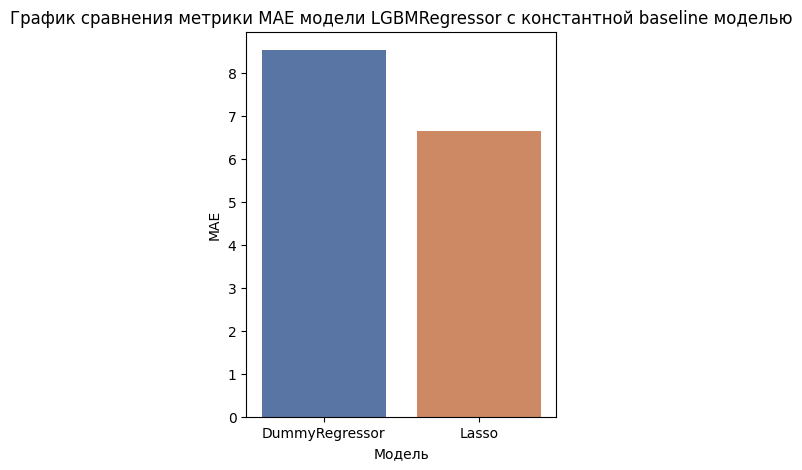

In [107]:
plt.figure(figsize=(4, 5))
sns.barplot(data=pd.DataFrame({'Model': ['DummyRegressor', 'Lasso'], 'MAE': [dummy_mae, best_model_MAE]}), x='Model', y='MAE')
plt.title('График сравнения метрики MAE модели LGBMRegressor с константной baseline моделью')
plt.xlabel('Модель')
plt.show();

`Средняя абсолютная ошибка` или **MAE** модели **Lasso** на тестовой выборке **ниже** чем, у `константной модели` **DummyRegressor**, что говорит о достаточной предсказательной способности, отличной от случайной.

### Дополнительная работа. Построение и оценка `Метамодели` (смешанный ансамбль моделей). 

В попытке добиться еще более лучшего результат попробуем использовать смешианный ансамбль моделей для прогнозирования новых данных. Это двухэтапный процесс. Первый шаг — использование каждой базовой модели для прогнозирования. Затем прогнозы собираются вместе и используются в качестве входных данных для модели смешивания, чтобы сделать окончательный прогноз.

In [108]:
# определим список регрессионных моделей для применения в качестве базовых
def get_models():
    models = list()
    models.append(('rf', RandomForestRegressor(**grid_rf.best_estimator_.named_steps.randomforestregressor.get_params())))
    models.append(('lgbm', LGBMRegressor(**grid_lgbm.best_estimator_.named_steps.lgbmregressor.get_params())))
    models.append(('lasso_lr_2', Lasso()))
    models.append(('ridge_lr_2', Ridge()))
    return models

# напишем функцию для получения предсказаний базовых моделей и обучения метамодели
def fit_ensemble(models, X_train, X_val, y_train, y_val):
    # масштабирование выборочной и тестовой выборок
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
    X_val_sc = scaler.transform(X_val)
    X_val_sc = pd.DataFrame(X_val_sc, columns=X_val.columns)
    # обучим все базовые модели
    meta_X = list()
    for name, model in models:
        if name in ['lasso_lr_1', 'ridge_lr_1', 'lasso_lr_2', 'ridge_lr_2']:
            model.fit(X_train_sc, y_train)
            # предсказания на валидационной выборке
            yhat = model.predict(X_val_sc)
        else:
            model.fit(X_train, y_train)
            # предсказания на валидационной выборке
            yhat = model.predict(X_val)
        # преобразуем прогнозы в матрицу с одним столбцом
        yhat = yhat.reshape(len(yhat), 1)
        # сохраним предсказания в качестве входного признака для метамодели
        meta_X.append(yhat)
    # создадим 2d-массив из прогнозов, каждый набор является входным элементом
    meta_X = np.hstack(meta_X)
    # зададим метамдель
    blender = RandomForestRegressor(random_state=RAND_ST, criterion='mae')
    # обучим метамодель на предсказаниях базовых моделей
    blender.fit(meta_X, y_val)
    return blender

# функция для предсказания ансамбля моделей на тестовой выборке
def predict_ensemble(models, blender, X_test):
    # сначала сделаем предсказания всех базовых моделей
    meta_X = list()
    for name, model in models:
        if name in ['lasso_lr_1', 'ridge_lr_1', 'lasso_lr_2', 'ridge_lr_2']:
            yhat = model.predict(X_test_sc)
        else:
            yhat = model.predict(X_test)
        # преобразуем прогнозы в матрицу с одним столбцом
        yhat = yhat.reshape(len(yhat), 1)
        # сохраним предсказания в качестве входного признака для метамодели
        meta_X.append(yhat)
    # создадим 2d-массив из прогнозов, каждый набор является входным элементом
    meta_X = np.hstack(meta_X)
    # полуичм окончательне предсказание
    return blender.predict(meta_X)

# дополнительно разобъем обучающую выборку на две (обучающую, валидационную)
X_train_ans, X_val_ans, y_train_ans, y_val_ans = train_test_split(X_train, y_train, test_size=0.25, random_state=RAND_ST)
# Выведем размерности выборок
print('Train: %s, Val: %s, Test: %s' % (X_train_ans.shape, X_val_ans.shape, X_test.shape))
# создадим список из базовых моделей
models = get_models()
# обучим ансамбль моделей
blender = fit_ensemble(models, X_train_ans, X_val_ans, y_train_ans, y_val_ans)
# получим предсказания для тестовой выборки
yhat = predict_ensemble(models, blender, X_test)
# оценим предсказания
score = mean_absolute_error(y_test, yhat)
print('MAE ансамбля моделей на тестовой выборке: %.3f' % score)

Train: (1307, 39), Val: (436, 39), Test: (582, 39)
MAE ансамбля моделей на тестовой выборке: 5.632


Нам удалось улучшить метрику **MAE** с использованием ансамбля базовых моделей. **MAE** `метамодели` **RandomForestRegressor** составил **5.632 гр.**. **Рекоменудется** использовать ансамбль моделей в данном случае, так как смешанный ансамбль полезен в том случае, если он работает лучше, чем любая из базовых моделей ансамбля.

## Общий вывод

**В ходе работы было выполнено:**
- загружены данные с базы данных **PostgreSQL** - 7 таблиц. Для удобства таблицы были сохранены в отдельные файлы формата `'.csv'`;
- проведен анализ всех таблиц (проверено наличие пропусков и аномалий с последующей их обработкой, изучены распределения признаков, построены наглядные графики);
- на основе имеющихся данных построены дополнительные признаки (агреггированные, производные, временные);
- данные объеденены в итоговую таблицу. Для объединенния использован метод `'inner'`. Таким образом в итоговую таблицу попали только те партии, для которых во всех таблицах есть данные. Исключены признаки, содержащие даты;
- проведен корреляционный анализ признаков, включая целевой;
- данные были разбиты на обучающую и валидационную выборки в соотношении 75% к 25%;
- в качестве `константной baseline модели` использована модель **DummyRegressor** по `среднему значению`;
- с подбором гиперпараметров и `кросс-валидации на 5-и фолдах` с помощью **GridSearchCV** обучено **5 моделей**: **'Lasso', 'Ridge', 'RandomForestRegressor', 'LGBMRegressor', 'NeuralNetwork (Pytorch)'**;
- выбрана лучшая модель по результатам метрики **MAE**;
- лучшая модель оценена на `тестовой (отложенной)` выборке и проведено сравнение с `константной baseline моделью`;
- проведено исследование `важности признаков` для предсказания температуры плавления;
- (**дополнительно**) обучена `метамодель` на основе ансамбля базовых моделей: . Получены предсказания на тестовой выборке, оценена метрика **MAE**;
- сделан **вывод и даны рекомендации** бизнесу.

Из интересных особенностей на этапе **EDA-исследования** выявлено следующее:
- чаще всего на одну партию приходится от **4 до 5 этапов нагрева**;
- есть партии, требующие так же либо меньшего количества этапов (**от 1 до 3**) или намного большего (**от 6 до 15**);
- `активная` и `реактивная` мощности **сильно положительно коррелируют**;
- в среднем `реактивная мощность` составляет порядка **0.7-0.8** от `активной мощности`;
- `медианнаяя` длительность одного этапа нагрева составляет - **2 мин. 27 сек**;
- есть партии, которые имеют отрицательную длительность между этапами. После просмотра многих партий выявлена та же самая ошибка в данных, связанная с тем, что не всегда после полуночи дата указана с учетом следующих суток;
- `'среднее'` значение объема газа, используемого для продувки сплава составляет **11**, `'медианное'` немного меньше - **9.8**. Видимо для некоторых партий используется больший объем газа для продувки;
- `межквартильный размах` значений объема подаваемого газа - **от 0 до 24**;
- в некторых партиях используется больший объем газа вплоть до **78**;
- не все типы `проволочных` и `сыпучих` материалов добавляются в сталь. Из `сыпучих` материалов чаще всего используются материалы **№14, №12, №15**. Реже - **№3, №4, №6**. Остальные практически не используются. Из `проволочных` материалов чаще всего используются материалы **№1, №2**. Остальные практически не используются. 
- `медианное значение` **начальной температуры** нагрева немного **ниже конечной** и составляет около **1580 гр.**;
- `межквартильный размах` **начальной температуры** намного больше, чем у **конечной температуры**, что говорит о большей вариабельности;
- у обоих температур есть **выбросы**, но у **начальной температуры** есть аномально низкие значения в районе **1200 - 1235 гр.**. По условиям задачи такие температуры аномальны ('Заказчик предупредил, что значения температуры ниже 1500 градусов — аномальные'). Удалим партии с тикими аномальными температурами.

**Вывод:**

В качестве итоговой модели, рекомендованной к внедрению, предлагается **Lasso** с **L1-регуляризацией**. `Средняя абсолютная ошибка` модели (метрика **MAE**) на тестовой выборке составила **6,65 градуса**, что безусловно ниже предела, установленного Заказчиком (`MAE не выше 6.8`).
Для модели **Lasso** самыми важными признаками в порядке убывания важности стали: `'active_power'`, `'reactive_power'`, `'time_between_cum'
- `начальная температура нагрева`;
- `суммарная мощность`;
- `активная мощность`;
- `реактивная мощность`;
- `суммарное время между началами этапов нагрева`.

    `Нейронная сеть` построенная с использованием **pytorch** показала хучдшие рездуьтаты, **MAE** на кросс-валидации - **6.549**. Для табличных данных быстрее и качественнее работают `линейные модели` и `модели основанные на деревьях`. `Нейронные сети` требуют подбора скрытых слоев, настройки параметров и как следствие большего времени на обучение.

    Так же крайне рекомендуется к внедрению `ансамбль из базовых моделей` (**Lasso, Ridge, RandomForest, LGBRegressor**) и метамодели **RandomForest**, которые показал на тестовой выборке значение **MAE** - **5.632**. Ансамбль моделей имеет ряд преимцществ, одним из которых является усреднение предсказательной способности базовых моделей на шумных данных и `меньшую среднюю абсолютную ошибку` .

**Рекомендации:**
- предоставить Заказчику информацию о найденных ошибках в данных (ошибки в датах, отсутствие информации о разных партиях в каждой из таблиц). В случае устранения проблем с искажением и потерей данных, можно попробовать обучить модель на большем объеме партий для улучшения предсказательной способности;
- замер предыдущей температуры нагрева с предыдущего этапа позволил бы более точно прогнозировать следующую температуру нагрева, ввиду автокорреляции.